# 人工智慧模型模擬麻醉醫生以評估手術中病人的清醒程度

## 0. 設置

In [1]:
# 支援 Python 2 以及 Python 3
from __future__ import division, print_function, unicode_literals

# 匯入常用模組
import numpy as np
import os
import time


# 設置一個固定的亂數種子 42，讓每次產生的亂數是相同的
# 也可以設定為其他值
np.random.seed(42)


# 匯入 Matplotlib，設定圖形相關參數
# 在此頁面中嵌入圖形，並且不需要再使用 .show() 呈現圖形
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 設定儲存圖形的位置
PROJECT_ROOT_DIR = ".\\final-project"
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# 定義一個儲存圖形的函式
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    # 密致布局，自動調整子圖參數
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 忽略無用的警告訊息
# SciPy issue #5998
# https://github.com/scipy/scipy/issues/5998
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 2. 取得資料

In [2]:
import pandas as pd
import os
DOCUMENT_PATH = os.path.join(".", "final-project")
print(os.getcwd())#打印出当前工作路径 


# 定義一個以 Pandas 讀入資料的函式
def load_document_data(document_path=DOCUMENT_PATH):
    csv_path = os.path.join(document_path, "ALL_16_except_X.csv")
    #print(csv_path)
    return pd.read_csv(csv_path)

# 執行上述讀入資料的函式
anesthesia = load_document_data()
anesthesia_copy = load_document_data()

C:\Users\User\Downloads


In [3]:
import pandas as pd
import os
DOCUMENT_PATH = os.path.join(".", "final-project")


# 定義一個以 Pandas 讀入資料的函式
def load_document_data(document_path=DOCUMENT_PATH):
    csv_path = os.path.join(document_path, "NTUH_OR69_Raw_Data_20141226_4.csv")
    return pd.read_csv(csv_path)


# 執行上述讀入資料的函式
anesthesia_test_set_two_surgery = load_document_data()
anesthesia_test_set_two_surgery_copy = load_document_data()

### 快速瀏覽資料

In [4]:
# 觀察 anesthesia 的前五行資料
anesthesia.head(2)

,Time,HR,PVC,SPO2,Pulse,NBP_Dia,NBP_Sys,NBP_Mean,ABP_Dia,ABP_Sys,...,BIS,SQI,EMG,SR,MAC,A_Doctor_value,B_Doctor_value,C_Doctor_value,Average_doctor_value,Awareness
0,2014/12/18 10:10,-1,-1,99.099998,96,-1,-1,-1,--,--,...,--,--,--,----,NaN,87.022252,92.645537,95.669870,91.77922,NaN
1,2014/12/18 10:10,-1,-1,99.300003,94,-1,-1,-1,--,--,...,--,--,--,----,NaN,86.330835,91.798641,95.396125,91.17520,NaN


In [5]:
#使得 describe() 也顯示類別屬性。
anesthesia.describe(include='all')

,Time,HR,PVC,SPO2,Pulse,NBP_Dia,NBP_Sys,NBP_Mean,ABP_Dia,ABP_Sys,...,BIS,SQI,EMG,SR,MAC,A_Doctor_value,B_Doctor_value,C_Doctor_value,Average_doctor_value,Awareness
count,18174,18174.000000,18174,18174.000000,18174.000000,18174.000000,18174.000000,18174.000000,18174,18174,...,18173,18174,18174,18174,0.0,18174.000000,18174.000000,18174.000000,18174.000000,0.0
unique,1390,NaN,33,NaN,NaN,NaN,NaN,NaN,2,2,...,83,91,59,80,NaN,NaN,NaN,NaN,NaN,NaN
top,2014/12/25 14:40,NaN,0,NaN,NaN,NaN,NaN,NaN,--,--,...,-1,100,27,0--,NaN,NaN,NaN,NaN,NaN,NaN
freq,24,NaN,9789,NaN,NaN,NaN,NaN,NaN,16765,16765,...,2141,4040,4560,14499,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,71.858094,NaN,93.674678,71.362496,68.361726,113.664906,78.726257,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.290838,49.175396,50.934851,48.800362,NaN
std,NaN,20.687399,NaN,23.352907,18.613599,19.346670,28.048750,20.259247,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.461959,9.750049,12.213434,10.274658,NaN
min,NaN,-1.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29.081102,22.304211,33.826842,38.517275,NaN
25%,NaN,64.000000,NaN,99.699997,62.000000,57.000000,99.000000,68.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,38.724595,43.309071,44.650715,43.345947,NaN
50%,NaN,71.000000,NaN,100.000000,70.000000,66.000000,114.000000,77.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,43.092500,46.733817,47.807607,45.759898,NaN
75%,NaN,85.000000,NaN,100.000000,84.000000,78.000000,129.000000,90.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,49.356691,51.324986,51.905317,49.063907,NaN


### 替换缺失值

In [6]:
#print(anesthesia.head(2))
#print("-------------------------------------------------------------------------")
anesthesia = anesthesia.replace([-1,'-1','--'],[np.nan,np.nan,np.nan])#將-1,'-1','--'都轉成NAN缺值
anesthesia = anesthesia.fillna(method='bfill')  # 用後面的值替换缺失值

anesthesia_test_set_two_surgery = anesthesia_test_set_two_surgery.replace([-1,'-1','--'],[np.nan,np.nan,np.nan])#將-1,'-1','--'都轉成NAN缺值
anesthesia_test_set_two_surgery = anesthesia_test_set_two_surgery.fillna(method='bfill')  # 用後面的值替换缺失值
#print(anesthesia.head(2))

In [7]:
# 檢查全部的columns是否有-1的缺值
anesthesia.columns
for column in anesthesia.columns:
    negative_one_index=anesthesia[(anesthesia[column]==-1)].index
anesthesia.loc[negative_one_index.values]    

,Time,HR,PVC,SPO2,Pulse,NBP_Dia,NBP_Sys,NBP_Mean,ABP_Dia,ABP_Sys,...,BIS,SQI,EMG,SR,MAC,A_Doctor_value,B_Doctor_value,C_Doctor_value,Average_doctor_value,Awareness


In [8]:
# 檢查全部的columns是否有'-1'的缺值
anesthesia.columns
for column in anesthesia.columns:
    negative_one_index=anesthesia[(anesthesia[column]=='-1')].index
anesthesia.loc[negative_one_index.values]    

,Time,HR,PVC,SPO2,Pulse,NBP_Dia,NBP_Sys,NBP_Mean,ABP_Dia,ABP_Sys,...,BIS,SQI,EMG,SR,MAC,A_Doctor_value,B_Doctor_value,C_Doctor_value,Average_doctor_value,Awareness


In [9]:
# 檢查anesthesia是否有NAN
sample_incomplete_rows = anesthesia[anesthesia.isnull().any(axis=1)].head(1)
anesthesia.loc[sample_incomplete_rows.index.values]
print(sample_incomplete_rows)

               Time    HR PVC       SPO2  Pulse  NBP_Dia  NBP_Sys  NBP_Mean  \
0  2014/12/18 10:10  93.0   0  99.099998   96.0     76.0    137.0      91.0   

  ABP_Dia ABP_Sys  ...  BIS  SQI EMG    SR MAC A_Doctor_value  B_Doctor_value  \
0      74     129  ...   91    0  59  ---- NaN      87.022252       92.645537   

   C_Doctor_value  Average_doctor_value  Awareness  
0        95.66987              91.77922        NaN  

[1 rows x 22 columns]


In [10]:
#沒有將object轉成float64,在畫BIS圖時,圖會失真
anesthesia["EMG"] = anesthesia['EMG'].astype('float64')
anesthesia["BIS"] = anesthesia['BIS'].astype('float64')
#anesthesia.dtypes

### 顯示目前評估方法(BIS)與三位醫生評估的差異 ==> 差異仍然很大 

Saving figure gradient_descent_paths_plot


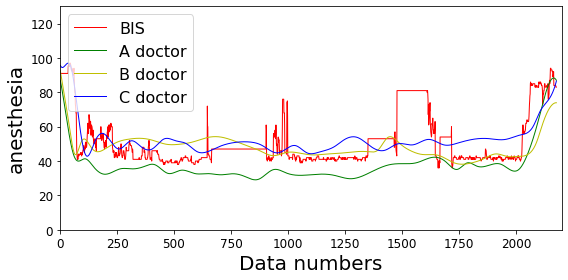

In [11]:
anesthesia_first_surgery_BIS = anesthesia.loc[0:2176,'BIS']
anesthesia_first_surgery_A = anesthesia.loc[0:2176,'A_Doctor_value']
anesthesia_first_surgery_B = anesthesia.loc[0:2176,'B_Doctor_value']
anesthesia_first_surgery_C = anesthesia.loc[0:2176,'C_Doctor_value']
anesthesia_first_surgery_len = range(1,len(anesthesia_first_surgery_A)+1,1)
anesthesia_first_surgery_len_array = np.array(anesthesia_first_surgery_len)

plt.figure(figsize=(8,4))
plt.plot(anesthesia_first_surgery_len_array, anesthesia_first_surgery_BIS, "r-", linewidth=1, label="BIS")
plt.plot(anesthesia_first_surgery_len_array, anesthesia_first_surgery_A, "g-", linewidth=1, label="A doctor")
plt.plot(anesthesia_first_surgery_len_array, anesthesia_first_surgery_B, "y-", linewidth=1, label="B doctor")
plt.plot(anesthesia_first_surgery_len_array, anesthesia_first_surgery_C, "b-", linewidth=1, label="C doctor")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=20)
plt.ylabel("anesthesia", fontsize=20)
plt.axis([0, 2200, 0, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

Saving figure attribute_histogram_plots


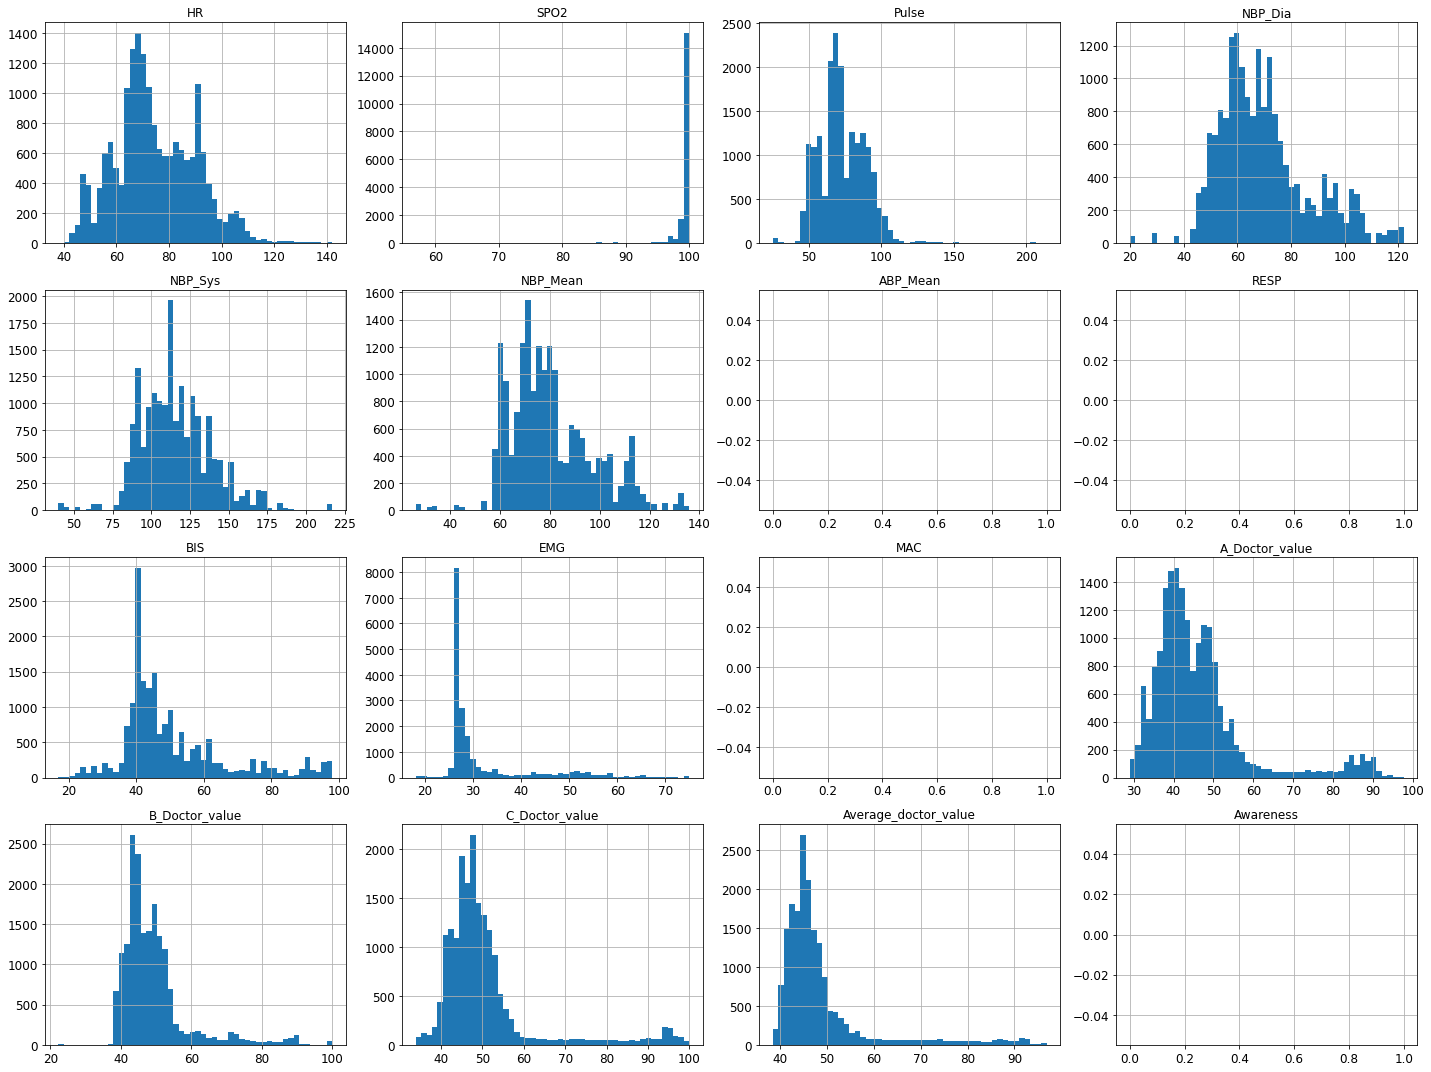

In [12]:
# 畫出每個數值屬性的直方圖
anesthesia.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### 相關係數 

In [13]:
# 使用 corr() 方法，輕鬆計算出每一對屬性之間的標準相關係數
corr_matrix = anesthesia.corr()
# 顯示Doctor_value 與其他屬性之間的標準相關係數
corr_matrix["Average_doctor_value"].sort_values(ascending=False)

Average_doctor_value    1.000000
C_Doctor_value          0.914894
A_Doctor_value          0.910489
B_Doctor_value          0.851637
BIS                     0.705965
EMG                     0.643608
NBP_Sys                 0.347670
NBP_Mean                0.210769
NBP_Dia                 0.119919
Pulse                   0.095326
HR                      0.090402
SPO2                   -0.118296
ABP_Mean                     NaN
RESP                         NaN
MAC                          NaN
Awareness                    NaN
Name: Average_doctor_value, dtype: float64

### 建立測試集與訓練集

In [14]:
anesthesia
anesthesia_test_set_two_surgey = anesthesia_test_set_two_surgery_copy
#print(anesthesia.head(2))
#print('===================================================================')
#print(anesthesia_test_set_two_surgery.head(2))

### 使用 Scikit-Learn 內建的 train_test_split 函式

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(anesthesia, test_size=0.2, random_state=42)

In [16]:
test_set.describe()

,HR,SPO2,Pulse,NBP_Dia,NBP_Sys,NBP_Mean,ABP_Mean,RESP,BIS,EMG,MAC,A_Doctor_value,B_Doctor_value,C_Doctor_value,Average_doctor_value,Awareness
count,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,0.0,0.0,3635.000000,3635.000000,0.0,3635.000000,3635.000000,3635.000000,3635.000000,0.0
mean,74.700963,99.380413,73.046768,69.761486,116.021733,80.323796,NaN,NaN,50.694635,31.709491,NaN,46.433015,49.241929,51.024332,48.899759,NaN
std,15.107539,2.612249,16.067603,17.084869,23.331152,17.288273,NaN,NaN,15.861892,9.556759,NaN,12.659100,9.772006,12.376093,10.409475,NaN
min,43.000000,60.299999,25.000000,20.000000,40.000000,26.000000,NaN,NaN,20.000000,18.000000,NaN,29.081102,23.458937,33.939662,38.519832,NaN
25%,65.000000,100.000000,63.000000,58.000000,100.000000,68.000000,NaN,NaN,41.000000,27.000000,NaN,38.639082,43.375272,44.722967,43.331096,NaN
50%,72.000000,100.000000,71.000000,66.000000,114.000000,77.000000,NaN,NaN,45.000000,28.000000,NaN,43.097049,46.800500,47.776397,45.819554,NaN
75%,86.000000,100.000000,84.000000,78.000000,129.000000,90.000000,NaN,NaN,56.000000,30.000000,NaN,49.418936,51.373569,51.905811,49.040508,NaN
max,142.000000,100.000000,206.000000,122.000000,217.000000,136.000000,NaN,NaN,98.000000,74.000000,NaN,94.338159,100.000000,100.000000,96.755137,NaN


### 分層取樣 (Stratified Sampling)

In [17]:
anesthesia["BIS"] = anesthesia['BIS'].astype('float64')

<AxesSubplot:>

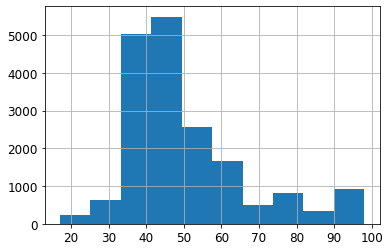

In [18]:
# 聽專家說，BIS是預測麻醉深度情況的一項重要屬性。
# 於是，我們希望測試集、訓練集裡的BIS分佈跟資料集裡的BIS分佈相同。
# 先觀察BIS分佈(Train_set)。
anesthesia["BIS"].hist()

<AxesSubplot:>

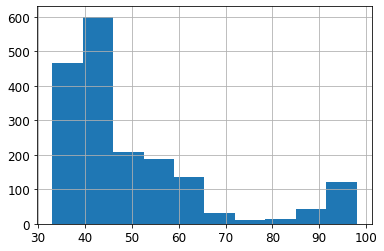

In [19]:
# 先觀察BIS分佈(test_set)。
anesthesia_test_set_two_surgery["BIS"].hist()

In [20]:
# 新增一個類別屬性 BIS_cat
# 把BIS分成四類
# 我們希望測試集、訓練集裡的BIS分佈跟原本資料集裡的BIS分佈相同。
anesthesia["BIS_cat"] = np.ceil(anesthesia["BIS"] / 10)
anesthesia_test_set_two_surgery["BIS_cat"] = np.ceil(anesthesia_test_set_two_surgery["BIS"] / 10)

In [21]:
#訓練集的BIS分佈
anesthesia["BIS_cat"].value_counts() / len(anesthesia)

5.0     0.420876
4.0     0.204853
6.0     0.145207
7.0     0.068174
8.0     0.048641
10.0    0.044459
3.0     0.034500
9.0     0.032574
2.0     0.000715
Name: BIS_cat, dtype: float64

In [22]:
#測試集的BIS分佈
anesthesia_test_set_two_surgery["BIS_cat"].value_counts() / len(anesthesia_test_set_two_surgery)

5.0     0.342684
4.0     0.336084
6.0     0.132013
7.0     0.084158
10.0    0.069857
9.0     0.026403
8.0     0.008801
Name: BIS_cat, dtype: float64

<AxesSubplot:>

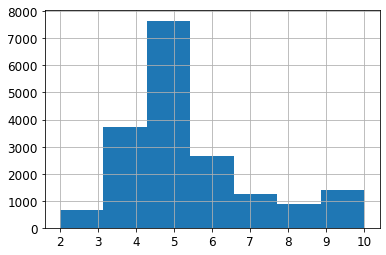

In [23]:
anesthesia["BIS_cat"].hist(bins=7)

<AxesSubplot:>

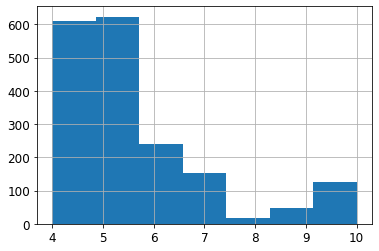

In [24]:
anesthesia_test_set_two_surgery["BIS_cat"].hist(bins=7)

In [25]:
# 分層取樣可以使測試集、訓練集裡的BIS分佈跟原本資料集裡的BIS分佈相同。
# 測試集(strat_test_set)、訓練集(strat_train_set)、原本資料集(anesthesia)。
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(anesthesia, anesthesia["BIS_cat"]):
    #此為訓練集    
    strat_train_set = anesthesia.loc[train_index]
    
    #從訓練集的13場手術中分割出來的測試集(strat_test_set)跟訓練集有同一場手術的資料，所以strat_test_set不能拿來測試
    #strat_test_set捨棄掉，另外用兩場手術(anesthesia_test_set_two_surgery)當作測試集
    strat_test_set = anesthesia.loc[test_index]

In [26]:
# 比較原始整體資料集、分層取樣、隨機分割的測試集、兩場手術測試集，這四者的BIS_value分佈

def anesthesia_cat_proportions(data):
    return data["BIS_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(anesthesia, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": anesthesia_cat_proportions(anesthesia),
    "Stratified": anesthesia_cat_proportions(strat_test_set),
    "Random": anesthesia_cat_proportions(test_set),
    "two_surgery_test_set":anesthesia_cat_proportions(anesthesia_test_set_two_surgery),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props["two_surgery. %error"] = 100 * compare_props["two_surgery_test_set"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,two_surgery_test_set,Rand. %error,Strat. %error,two_surgery. %error
2.0,0.000715,0.000550,0.001100,NaN,53.837689,-23.102310,NaN
3.0,0.034500,0.034653,0.030261,NaN,-12.285528,0.445308,NaN
4.0,0.204853,0.204620,0.212105,0.336084,3.539831,-0.113557,64.060798
5.0,0.420876,0.420792,0.411554,0.342684,-2.214820,-0.019934,-18.578325
6.0,0.145207,0.145215,0.143879,0.132013,-0.914887,0.004877,-9.086475
7.0,0.068174,0.068207,0.069876,0.084158,2.496378,0.047680,23.445928
8.0,0.048641,0.048955,0.051169,0.008801,5.197832,0.645506,-81.906426
9.0,0.032574,0.032453,0.032462,0.026403,-0.343321,-0.370730,-18.945678
10.0,0.044459,0.044554,0.047593,0.069857,7.048565,0.214440,57.126344


In [27]:
# 刪除BIS_cat屬性，把資料集恢復原狀
for set_ in (strat_train_set, strat_test_set,anesthesia_test_set_two_surgery):
    set_.drop("BIS_cat", axis=1, inplace=True)

## 3. 觀察資料

## 4. 處理資料

In [28]:
# 分成屬性 (輸入) 與標籤 (輸出)

#分層取樣後的訓練集
anesthesia_train_set = strat_train_set 
anesthesia_train_set_labels = strat_train_set["Average_doctor_value"].copy()

anesthesia_test_set = strat_test_set
anesthesia_test_set_labels = strat_test_set["Average_doctor_value"].copy()

anesthesia_test_set_two_surgery
anesthesia_test_set_two_surgery_labels = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

In [29]:
# 分成屬性 (輸入) 與標籤 (輸出)

#分層取樣後的訓練集(原始資料的90%)
anesthesia_train_set = strat_train_set 
anesthesia_train_set_labels = strat_train_set["Average_doctor_value"].copy()

#另外2場2014年的手術當成測試集
anesthesia_test_set_two_surgery
anesthesia_test_set_two_surgery_labels = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

### 資料轉換流水線

In [30]:
from sklearn.base import BaseEstimator,TransformerMixin

class process_data(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X_copy = X.copy()
        #只留下BIS、EMG、NBP_Sys當作訓練參數
        del X_copy ['Time']
        del X_copy ['ABP_Dia']
        del X_copy ['ABP_Sys']
        del X_copy ['ABP_Mean']
        del X_copy ['RESP']
        del X_copy ['SR']
        del X_copy ['MAC']
        del X_copy ['PVC']
        #del X_copy ['BIS']
        #del X_copy ['EMG']
        del X_copy ['SPO2']
        del X_copy ['SQI']
        del X_copy ['Awareness']
        del X_copy ['HR']
        del X_copy ['Pulse'] 
        del X_copy ['NBP_Dia']
        #del X_copy ['NBP_Sys']
        del X_copy ['NBP_Mean']
        
        del X_copy ['A_Doctor_value']    
        del X_copy ['B_Doctor_value']  
        del X_copy ['C_Doctor_value']  
        del X_copy ['Average_doctor_value']  
        return X_copy

In [31]:
process_train_set_function = process_data()
anesthesia_process_train_set = process_train_set_function.transform(anesthesia_train_set)
anesthesia_train_parameter = list(anesthesia_process_train_set)
print(anesthesia_train_parameter)
print(anesthesia_process_train_set.head())

['NBP_Sys', 'BIS', 'EMG']
       NBP_Sys   BIS   EMG
4224      98.0  42.0  27.0
11579    113.0  38.0  26.0
7920      85.0  40.0  27.0
10751    103.0  43.0  26.0
14067     98.0  54.0  24.0


In [32]:
process_test_set_function = process_data()
anesthesia_process_test_set_two_surgery = process_test_set_function.transform(anesthesia_test_set_two_surgery)
anesthesia_test_parameter = list(anesthesia_process_test_set_two_surgery)

#### 特徵標準化 

In [33]:
# 標準化 (Standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(anesthesia_process_train_set)
standardScaleResult = scaler.transform(anesthesia_process_train_set)
print(standardScaleResult)

[[-0.77376979 -0.54130349 -0.48617907]
 [-0.12532081 -0.79632621 -0.59294239]
 [-1.3357589  -0.66881485 -0.48617907]
 ...
 [-0.81699972 -0.2225251   0.47469073]
 [ 0.69604789 -0.47754781 -0.05912583]
 [ 0.26374857  0.73381009 -0.37941576]]


In [34]:
# 觀察各種輸入屬性經過標準化縮放之後的平均值
standardScaleResult.mean(axis = 0)

array([8.40609069e-17, 9.64419707e-17, 6.95077267e-17])

In [35]:
# 觀察各種輸入屬性經過標準化縮放之後的標準差
standardScaleResult.std(axis = 0)

array([1., 1., 1.])

In [36]:
# 觀察各種輸入屬性經過標準化縮放之後的最小值
standardScaleResult.min(axis = 0)

array([-3.28110584, -2.13519547, -1.44704888])

In [37]:
# 觀察各種輸入屬性經過標準化縮放之後的最大值
standardScaleResult.max(axis = 0)

array([4.3705921 , 3.02901454, 4.63845987])

In [38]:
# 最小-最大縮放 (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(anesthesia_process_train_set)
minMaxScaleResult = scaler.transform(anesthesia_process_train_set)
print(minMaxScaleResult)

[[0.32768362 0.30864198 0.15789474]
 [0.41242938 0.25925926 0.14035088]
 [0.25423729 0.28395062 0.15789474]
 ...
 [0.3220339  0.37037037 0.31578947]
 [0.51977401 0.32098765 0.22807018]
 [0.46327684 0.55555556 0.1754386 ]]


#### 數值流水線

In [39]:
# 建立一個對於數值屬性做前處理的流水線
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#column

num_pipeline = Pipeline([
        ('process_data', process_data()),
        ('std_scaler', StandardScaler()),
    ])


In [40]:
anesthesia_num_tr = num_pipeline.fit_transform(anesthesia_train_set)
anesthesia_num_tr

array([[-0.77376979, -0.54130349, -0.48617907],
       [-0.12532081, -0.79632621, -0.59294239],
       [-1.3357589 , -0.66881485, -0.48617907],
       ...,
       [-0.81699972, -0.2225251 ,  0.47469073],
       [ 0.69604789, -0.47754781, -0.05912583],
       [ 0.26374857,  0.73381009, -0.37941576]])

In [41]:
anesthesia_train_set["Awareness"] = anesthesia_train_set["Awareness"].astype('object')

#### 數值與類別流水線

In [42]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20.

In [43]:
# 把數值屬性以及類別屬性的前處理連結起來，形成一個完整的資料轉換流水線
num_attribs = list(anesthesia_train_set)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

In [44]:
# 執行整條資料轉換流水線
anesthesia_train_set_prepared = full_pipeline.fit_transform(anesthesia_train_set)
print(anesthesia_train_set_prepared)

[[-0.77376979 -0.54130349 -0.48617907]
 [-0.12532081 -0.79632621 -0.59294239]
 [-1.3357589  -0.66881485 -0.48617907]
 ...
 [-0.81699972 -0.2225251   0.47469073]
 [ 0.69604789 -0.47754781 -0.05912583]
 [ 0.26374857  0.73381009 -0.37941576]]


#### 完整的流水線 

In [45]:
# 建立一個完整的流水線
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
        ('process_data', process_data()),
        ('std_scaler', StandardScaler()),
    ])

In [46]:
anesthesia_train_set_prepared = full_pipeline.fit_transform(anesthesia_train_set)
print(anesthesia_train_set_prepared)

[[-0.77376979 -0.54130349 -0.48617907]
 [-0.12532081 -0.79632621 -0.59294239]
 [-1.3357589  -0.66881485 -0.48617907]
 ...
 [-0.81699972 -0.2225251   0.47469073]
 [ 0.69604789 -0.47754781 -0.05912583]
 [ 0.26374857  0.73381009 -0.37941576]]


## 5. 選擇模型與訓練模型

### 使用訓練集，進行訓練與評估

In [168]:
anesthesia_train_set_prepared = full_pipeline.fit_transform(anesthesia_train_set)

anesthesia_test_set_prepared = full_pipeline.fit_transform(anesthesia_test_set)
anesthesia_test_set_two_surgery_prepared = full_pipeline.fit_transform(anesthesia_test_set_two_surgery)

### 線性迴歸模型

In [169]:
# 先訓練一個線性回歸模型
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
# 訓練完成

LinearRegression()

In [170]:
# 用剛訓練好的線性回歸模型來做預測，並印出結果
print("Predictions:", lin_reg.predict(anesthesia_train_set_prepared))

Predictions: [43.28692665 43.05412574 41.58940224 ... 47.57272998 47.75547754
 51.57788254]


In [171]:
# 印出正確答案來跟以上預測結果做比較
print("Labels:", list(anesthesia_train_set_labels[0:5]))

Labels: [42.60972752, 44.86895009, 44.46253577, 41.95304915, 43.14072171]


In [172]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測
anesthesia_train_set_predictions = lin_reg.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
lin_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_train_set_predictions)
lin_rmse = np.sqrt(lin_mse)
print('RMSE=', lin_rmse)

RMSE= 6.691892250012658


### 交互驗證作更好的評估

In [173]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測
anesthesia_train_set_predictions = lin_reg.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
lin_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_train_set_predictions)
lin_rmse = np.sqrt(lin_mse)

In [174]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_mean_scores = lin_rmse_scores.mean()
print("cross_val_score mean RMSE =",lin_rmse_mean_scores)

cross_val_score mean RMSE = 6.694666463281754


In [175]:
def display_scores(scores):
    print("Cross_val_RMSE:", scores)
    print("Cross_val_Mean RMSE:", scores.mean())
    print("Cross_val_RMSE Standard deviation:", scores.std())

In [176]:
display_scores(lin_rmse_scores)

Cross_val_RMSE: [6.95381581 6.63169434 6.89991028 6.56747464 6.48594172 6.71977349
 6.67427638 6.47112936 6.74167262 6.80097601]
Cross_val_Mean RMSE: 6.694666463281754
Cross_val_RMSE Standard deviation: 0.15411649126173188


In [177]:
#print(anesthesia_test_set_original.head())
y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery) # 注意：這裡不是用 fit_transform，而是 transform
lin_reg_predictions = lin_reg.predict(X_test_prepared)

lin_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, lin_reg_predictions)
lin_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, lin_reg_predictions)
lin_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, lin_reg_predictions)
lin_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, lin_reg_predictions)

lin_reg_test_rmse_for_first_Doctor = np.sqrt(lin_reg_mse_for_first_Doctor)
lin_reg_test_rmse_for_second_Doctor = np.sqrt(lin_reg_mse_for_second_Doctor)
lin_reg_test_rmse_for_third_Doctor= np.sqrt(lin_reg_mse_for_third_Doctor)
lin_reg_test_rmse_for_3Doctors_average = np.sqrt(lin_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("lin_reg_test_rmse_for_first_Doctor_labels =",lin_reg_test_rmse_for_first_Doctor)
print("lin_reg_test_rmse_for_second_Doctor_labels =",lin_reg_test_rmse_for_second_Doctor)
print("lin_reg_test_rmse_for_third_Doctor_labels =",lin_reg_test_rmse_for_third_Doctor)
print("lin_reg_test_rmse_for_3Doctors_average_labels =",lin_reg_test_rmse_for_3Doctors_average)


<class 'pandas.core.series.Series'>
lin_reg_test_rmse_for_first_Doctor_labels = 7.843397426795991
lin_reg_test_rmse_for_second_Doctor_labels = 8.323581044366309
lin_reg_test_rmse_for_third_Doctor_labels = 6.308354441079495
lin_reg_test_rmse_for_3Doctors_average_labels = 6.272183431710838


In [178]:
lin_reg_train_score = lin_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
lin_reg_test_score = lin_reg.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)

In [179]:
print("lin_reg.intercept_=",lin_reg.intercept_)
print("lin_reg.coef_=",lin_reg.coef_) 
print("y=",lin_reg.intercept_,"+",lin_reg.coef_[0],"*X1","+",lin_reg.coef_[1],"*X2","+",
      lin_reg.coef_[2],"*X3")

lin_reg.intercept_= 48.78663081123992
lin_reg.coef_= [1.96517697 4.65147855 3.0055757 ]
y= 48.78663081123992 + 1.9651769701752 *X1 + 4.651478547011406 *X2 + 3.005575696012559 *X3


### 多階線性迴歸模型

1
find_order_lin_reg_train_score = 0.5748446736118774
find_order_lin_reg_train_score = 0.4744876399281358
2
find_order_lin_reg_train_score = 0.7118383277910059
find_order_lin_reg_train_score = 0.5810097382848742
3
find_order_lin_reg_train_score = 0.7344947163820792
find_order_lin_reg_train_score = 0.5704283870008708
4
find_order_lin_reg_train_score = 0.7574952452000631
find_order_lin_reg_train_score = 0.6070782556256128
5
find_order_lin_reg_train_score = 0.7772656593140337
find_order_lin_reg_train_score = 0.600781456164498
6
find_order_lin_reg_train_score = 0.7946169726380354
find_order_lin_reg_train_score = 0.5275943208452083
7
find_order_lin_reg_train_score = 0.8195063873224177
find_order_lin_reg_train_score = 0.44438026631770944
8
find_order_lin_reg_train_score = 0.8290684734999902
find_order_lin_reg_train_score = 0.15034129463118018
Saving figure gradient_descent_paths_plot


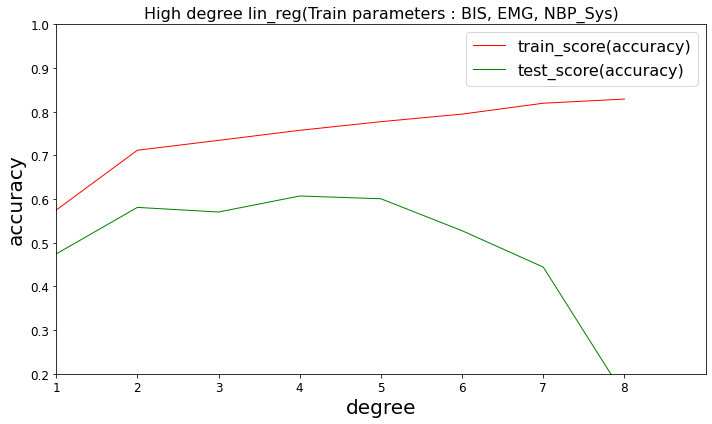

In [180]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
model_train_score_accuracy = []
model_test_score_accuracy = []
model_array = ["1","2","3","4","5","6","7","8"]

for i in range(1,9):
    print(i)
    find_order_lin_reg = Pipeline((
        ("poly_features",PolynomialFeatures(degree=i, include_bias=False)),
        ("lin_reg",LinearRegression()),
    ))
    find_order_lin_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
    #anesthesia_predictions = find_order_lin_reg.predict(anesthesia_train_set_prepared)
    
    # 計算預測結果與正確答案之間的 RMSE
    find_order_lin_reg_train_score = find_order_lin_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
    find_order_lin_reg_test_score = find_order_lin_reg.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)

    model_train_score_accuracy.append(find_order_lin_reg_train_score)
    model_test_score_accuracy.append(find_order_lin_reg_test_score)
    print("find_order_lin_reg_train_score =",find_order_lin_reg_train_score)
    print("find_order_lin_reg_train_score =",find_order_lin_reg_test_score)

#print(model_train_score_accuracy)
#print(model_test_score_accuracy)

plt.figure(figsize=(10,6))
plt.plot(model_array, model_train_score_accuracy, "r-", linewidth=1, label="train_score(accuracy)")
plt.plot(model_array, model_test_score_accuracy, "g-", linewidth=1, label="test_score(accuracy)")

plt.title("High degree lin_reg(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper right", fontsize=16)
plt.xlabel("degree", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.axis([ 0, 8, 0.2, 1])
save_fig("gradient_descent_paths_plot")
plt.show()


In [181]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

Four_degree_lin_reg = Pipeline((
    ("poly_features",PolynomialFeatures(degree=4, include_bias=False)),
    ("lin_reg",LinearRegression()),
))
Four_degree_lin_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('lin_reg', LinearRegression())])

In [182]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測
anesthesia_train_set_predictions = Four_degree_lin_reg.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Four_degree_lin_reg_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_train_set_predictions)
Four_degree_lin_reg_rmse = np.sqrt(Four_degree_lin_reg_mse)
print('Four_degree_lin_reg_rmse = ',Four_degree_lin_reg_rmse)

Four_degree_lin_reg_rmse =  5.054000219924527


In [183]:
from sklearn.model_selection import cross_val_score

Four_degree_lin_reg_scores = cross_val_score(Four_degree_lin_reg, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                             scoring="neg_mean_squared_error", cv=25)
Four_degree_lin_reg_rmse_scores = np.sqrt(-Four_degree_lin_reg_scores)
Four_degree_lin_reg_rmse_mean_scores = Four_degree_lin_reg_rmse_scores.mean()
print("cross_val_score mean RMSE =",Four_degree_lin_reg_rmse_mean_scores)
print(Four_degree_lin_reg_rmse_scores)

cross_val_score mean RMSE = 5.091465799976358
[5.03910546 5.24199623 5.16829518 4.99884613 5.08596894 5.33361648
 5.40735244 4.92141923 4.60125028 5.27722243 5.09901099 5.69934438
 5.04672085 5.07925652 4.93389346 5.21016179 5.06741004 4.67980386
 4.94334032 4.79455607 5.40550351 5.2258115  4.89764534 5.01351487
 5.11559869]


In [67]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測
anesthesia_test_set_predictions = Four_degree_lin_reg.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Four_degree_lin_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
Four_degree_lin_reg_test_set_rmse = np.sqrt(Four_degree_lin_reg_test_set_mse)
print('Four_degree_lin_reg_test_set_rmse = ',Four_degree_lin_reg_test_set_rmse)

Four_degree_lin_reg_test_set_rmse =  4.892139662940128


In [68]:
#print(anesthesia_test_set_original.head())
y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery) # 注意：這裡不是用 fit_transform，而是 transform
Four_orders_lin_reg_predictions = Four_degree_lin_reg.predict(X_test_prepared)

Four_orders_lin_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, Four_orders_lin_reg_predictions)
Four_orders_lin_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, Four_orders_lin_reg_predictions)
Four_orders_lin_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, Four_orders_lin_reg_predictions)
Four_orders_lin_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, Four_orders_lin_reg_predictions)

Four_degree_lin_reg_test_rmse_for_first_Doctor = np.sqrt(Four_orders_lin_reg_mse_for_first_Doctor)
Four_degree_lin_reg_test_rmse_for_second_Doctor = np.sqrt(Four_orders_lin_reg_mse_for_second_Doctor)
Four_degree_lin_reg_test_rmse_for_third_Doctor= np.sqrt(Four_orders_lin_reg_mse_for_third_Doctor)
Four_degree_lin_reg_test_rmse_for_3Doctors_average = np.sqrt(Four_orders_lin_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("Four_degree_lin_reg_test_rmse_for_first_Doctor_labels =",Four_degree_lin_reg_test_rmse_for_first_Doctor)
print("Four_degree_lin_reg_test_rmse_for_second_Doctor_labels =",Four_degree_lin_reg_test_rmse_for_second_Doctor)
print("Four_degree_lin_reg_test_rmse_for_third_Doctor_labels =",Four_degree_lin_reg_test_rmse_for_third_Doctor)
print("Four_degree_lin_reg_test_rmse_for_3Doctors_average_labels =",Four_degree_lin_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
Four_degree_lin_reg_test_rmse_for_first_Doctor_labels = 7.302827244618094
Four_degree_lin_reg_test_rmse_for_second_Doctor_labels = 7.7065271382183465
Four_degree_lin_reg_test_rmse_for_third_Doctor_labels = 5.300646027690724
Four_degree_lin_reg_test_rmse_for_3Doctors_average_labels = 5.423508374372337


In [69]:
Four_degree_lin_reg_train_score = Four_degree_lin_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Four_degree_lin_reg_test_score = Four_degree_lin_reg.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("Four_degree_lin_reg_train_score =",Four_degree_lin_reg_train_score)
print("Four_degree_lin_reg_train_score =",Four_degree_lin_reg_test_score)

Four_degree_lin_reg_train_score = 0.7574952452000631
Four_degree_lin_reg_train_score = 0.7776651001951077


In [70]:
Four_degree_lin_reg_train_score = Four_degree_lin_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Four_degree_lin_reg_test_score = Four_degree_lin_reg.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("Four_degree_lin_reg_train_score =",Four_degree_lin_reg_train_score)
print("Four_degree_lin_reg_train_score =",Four_degree_lin_reg_test_score)

Four_degree_lin_reg_train_score = 0.7574952452000631
Four_degree_lin_reg_train_score = 0.6070782556256128


In [75]:
print("Four_degree_lin_reg.intercept_=",Four_degree_lin_reg ["lin_reg"].intercept_)
print("---------------------------------------")
features = pd.DataFrame(Four_degree_lin_reg ["lin_reg"].coef_,
                     Four_degree_lin_reg["poly_features"].get_feature_names(list(anesthesia_process_test_set_two_surgery)))
print(features)

Four_degree_lin_reg.intercept_= 44.206160995784465
---------------------------------------
                          0
NBP_Sys            1.255260
BIS               -0.066636
EMG                0.678826
NBP_Sys^2          1.747491
NBP_Sys BIS        0.567186
NBP_Sys EMG        0.201695
BIS^2              3.835616
BIS EMG           -0.885728
EMG^2              0.007512
NBP_Sys^3         -0.111036
NBP_Sys^2 BIS      1.166612
NBP_Sys^2 EMG     -0.193929
NBP_Sys BIS^2      0.541078
NBP_Sys BIS EMG    0.457598
NBP_Sys EMG^2      0.068111
BIS^3             -0.301843
BIS^2 EMG          1.541426
BIS EMG^2          1.065071
EMG^3             -0.262896
NBP_Sys^4         -0.080227
NBP_Sys^3 BIS     -0.135696
NBP_Sys^3 EMG      0.121116
NBP_Sys^2 BIS^2   -0.847897
NBP_Sys^2 BIS EMG  0.636551
NBP_Sys^2 EMG^2   -0.192176
NBP_Sys BIS^3      0.072478
NBP_Sys BIS^2 EMG -0.308617
NBP_Sys BIS EMG^2 -0.009982
NBP_Sys EMG^3     -0.123385
BIS^4             -0.215038
BIS^3 EMG          0.347434
BIS^2 EMG^2  

In [76]:
intercept = Four_degree_lin_reg["lin_reg"].intercept_
coef = Four_degree_lin_reg["lin_reg"].coef_
coef_name = Four_degree_lin_reg["poly_features"].get_feature_names(list(anesthesia_process_test_set_two_surgery))

for x in range(34):#coef 的長度為34，所以設定range(34)
    coef[x] = round(coef[x],2)#取到小數點後兩位
    
print("Four_degree_lin_reg")
print("y =",intercept,"+",coef[0],coef_name[0],"+",coef[1],coef_name[1],"+",coef[2],coef_name[2],"+",coef[3],coef_name[3],
      "+",coef[4],coef_name[4],"+",coef[5],coef_name[5],"+",coef[6],coef_name[6],"+",coef[7],coef_name[7],
      "+",coef[8],coef_name[8],"+",coef[9],coef_name[9],"+",coef[10],coef_name[10],"+",coef[11],coef_name[11],
      "+",coef[12],coef_name[12],"+",coef[13],coef_name[13],"+",coef[14],coef_name[14],"+",coef[15],coef_name[15],
      "+",coef[16],coef_name[16],"+",coef[17],coef_name[17],"+",coef[18],coef_name[18],"+",coef[19],coef_name[19],
      "+",coef[20],coef_name[20],"+",coef[21],coef_name[21],"+",coef[22],coef_name[22],"+",coef[23],coef_name[23],
      "+",coef[24],coef_name[24],"+",coef[25],coef_name[25],"+",coef[26],coef_name[26],"+",coef[27],coef_name[27],
      "+",coef[28],coef_name[28],"+",coef[29],coef_name[29],"+",coef[30],coef_name[30],"+",coef[31],coef_name[31],
      "+",coef[32],coef_name[32],"+",coef[33],coef_name[33])

Four_degree_lin_reg
y = 44.206160995784465 + 1.26 NBP_Sys + -0.07 BIS + 0.68 EMG + 1.75 NBP_Sys^2 + 0.57 NBP_Sys BIS + 0.2 NBP_Sys EMG + 3.84 BIS^2 + -0.89 BIS EMG + 0.01 EMG^2 + -0.11 NBP_Sys^3 + 1.17 NBP_Sys^2 BIS + -0.19 NBP_Sys^2 EMG + 0.54 NBP_Sys BIS^2 + 0.46 NBP_Sys BIS EMG + 0.07 NBP_Sys EMG^2 + -0.3 BIS^3 + 1.54 BIS^2 EMG + 1.07 BIS EMG^2 + -0.26 EMG^3 + -0.08 NBP_Sys^4 + -0.14 NBP_Sys^3 BIS + 0.12 NBP_Sys^3 EMG + -0.85 NBP_Sys^2 BIS^2 + 0.64 NBP_Sys^2 BIS EMG + -0.19 NBP_Sys^2 EMG^2 + 0.07 NBP_Sys BIS^3 + -0.31 NBP_Sys BIS^2 EMG + -0.01 NBP_Sys BIS EMG^2 + -0.12 NBP_Sys EMG^3 + -0.22 BIS^4 + 0.35 BIS^3 EMG + -0.59 BIS^2 EMG^2 + -0.3 BIS EMG^3 + 0.15 EMG^4


C:\Users\User\anaconda3\envs\torch-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [77]:
Four_degree_lin_regression = [
                               Four_degree_lin_reg_train_score,
                               Four_degree_lin_reg_test_score,
                               Four_degree_lin_reg_rmse ,
                               Four_degree_lin_reg_rmse_mean_scores,
                               Four_degree_lin_reg_test_rmse_for_3Doctors_average]

compare_props = pd.DataFrame({
    "": ["train_score(accuracy)", "test_score(accuracy)", "train_set RMSE", "cross_val_score_mean RMSE",
         "test_set RMSE with 3 Doctors average labels"],
    "Four_degree_lin_reg": Four_degree_lin_regression,

})
compare_props

,,Four_degree_lin_reg
0,train_score(accuracy),0.757495
1,test_score(accuracy),0.607078
2,train_set RMSE,5.054000
3,cross_val_score_mean RMSE,5.091466
4,test_set RMSE with 3 Doctors average labels,5.423508


### 決策樹模型(DecisionTree)

In [79]:
# 選一個複雜一點的模型來訓練
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
# 訓練完成

DecisionTreeRegressor(random_state=42)

['NBP_Sys', 'BIS', 'EMG']


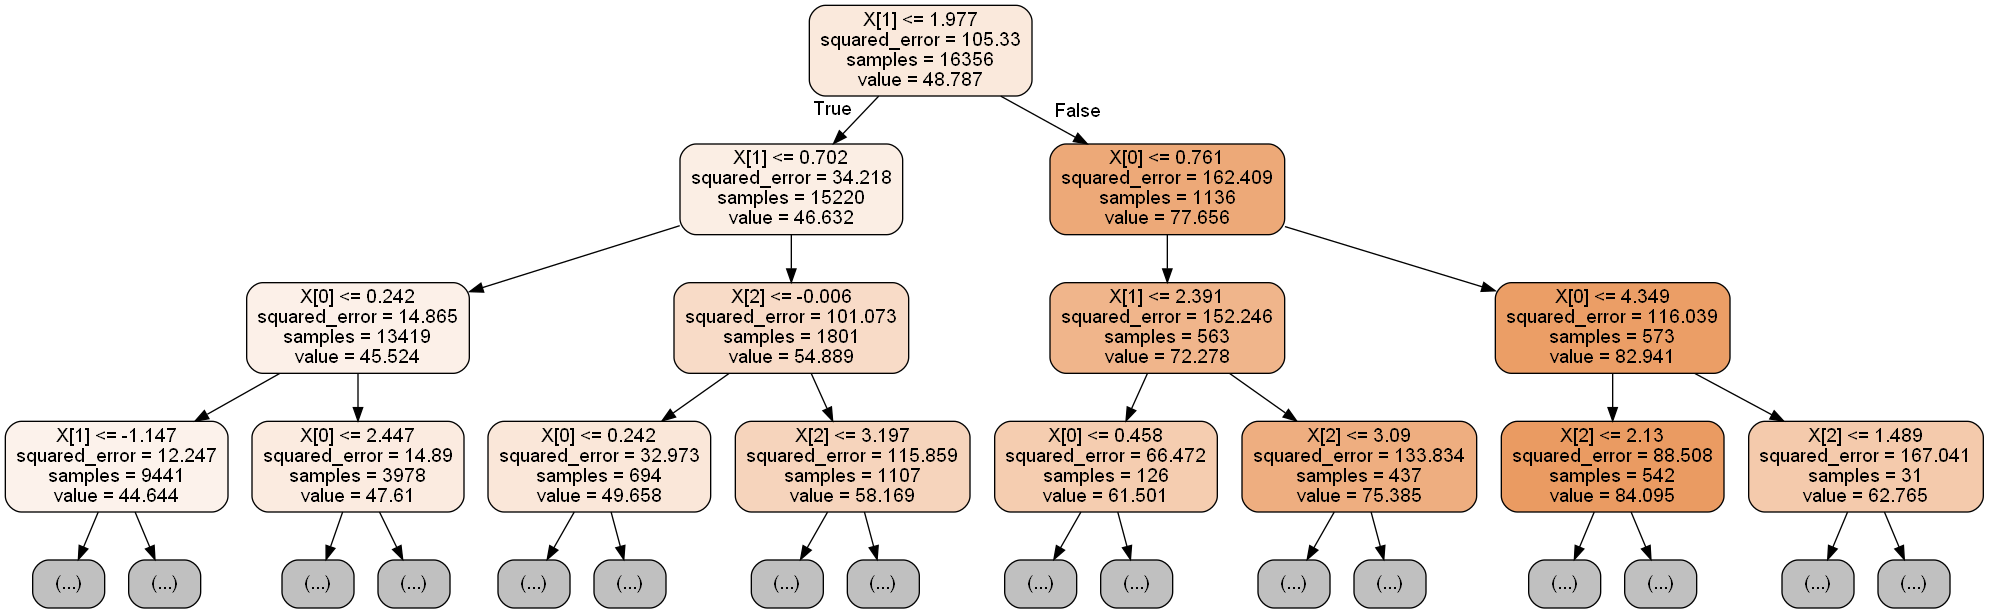

In [80]:
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

import os 
os.environ["PATH"] += os.pathsep + 'C://Program Files//Graphviz//bin'

print(anesthesia_train_parameter)
dot_data =  tree.export_graphviz(tree_reg,
                                 max_depth=3,
                                 filled=True,
                                 rounded=True)

#jupyter 顯示圖片
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [81]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
# 所有訓練集的資料拿來預測
anesthesia_tree_reg_predictions = tree_reg.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
tree_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_tree_reg_predictions)
tree_rmse = np.sqrt(tree_mse)
print('tree_rmse = ',tree_rmse)

tree_rmse =  1.2530002388692358


In [82]:
scores = cross_val_score(tree_reg, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_mean_scores = tree_rmse_scores.mean()
print("cross_val_score mean RMSE =",tree_rmse_mean_scores)

cross_val_score mean RMSE = 2.808003800014169


In [83]:
display_scores(tree_rmse_scores)

Cross_val_RMSE: [3.05240877 2.33485805 3.27468238 2.35735106 3.14733752 2.95483074
 2.48575273 2.69752638 3.05360961 2.72168075]
Cross_val_Mean RMSE: 2.808003800014169
Cross_val_RMSE Standard deviation: 0.32015744758056325


In [84]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測
anesthesia_test_set_predictions = tree_reg.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
tree_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
tree_reg_test_set_rmse = np.sqrt(tree_reg_test_set_mse)
print('tree_reg_test_set_rmse = ',tree_reg_test_set_rmse)

tree_reg_test_set_rmse =  6.313111307689824


In [85]:
tree_reg_train_score = tree_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
tree_reg_test_score = tree_reg.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("tree_reg_train_score =",tree_reg_train_score)
print("tree_reg_train_score =",tree_reg_test_score)

tree_reg_train_score = 0.9850943110955586
tree_reg_train_score = 0.6297484901895538


In [86]:
tree_reg_train_score = tree_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
tree_reg_test_score = tree_reg.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("tree_reg_train_score =",tree_reg_train_score)
print("tree_reg_train_score =",tree_reg_test_score)

tree_reg_train_score = 0.9850943110955586
tree_reg_train_score = 0.141652675196416


In [87]:
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

tree_reg_predictions = tree_reg.predict(X_test_prepared)

tree_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, tree_reg_predictions)
tree_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, tree_reg_predictions)
tree_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, tree_reg_predictions)
tree_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, tree_reg_predictions)

tree_reg_test_rmse_for_first_Doctor = np.sqrt(tree_reg_mse_for_first_Doctor)
tree_reg_test_rmse_for_second_Doctor = np.sqrt(tree_reg_mse_for_second_Doctor)
tree_reg_test_rmse_for_third_Doctor= np.sqrt(tree_reg_mse_for_third_Doctor)
tree_reg_test_rmse_for_3Doctors_average = np.sqrt(tree_reg_mse_for_3Doctors_average)


print(type(y_test_first_Doctor))
print("tree_reg_test_rmse_for_first_Doctor_labels =",tree_reg_test_rmse_for_first_Doctor)
print("tree_reg_test_rmse_for_second_Doctor_labels =",tree_reg_test_rmse_for_second_Doctor)
print("tree_reg_test_rmse_for_third_Doctor_labels =",tree_reg_test_rmse_for_third_Doctor)
print("tree_reg_test_rmse_for_3Doctors_average_labels =",tree_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
tree_reg_test_rmse_for_first_Doctor_labels = 8.751567639114707
tree_reg_test_rmse_for_second_Doctor_labels = 10.36420650085312
tree_reg_test_rmse_for_third_Doctor_labels = 7.83188359853382
tree_reg_test_rmse_for_3Doctors_average_labels = 8.016020373554241


In [91]:
tree_regression = [
                               tree_reg_train_score,
                               tree_reg_test_score,
                               tree_rmse ,
                               tree_rmse_mean_scores,
                               #7.912644,
                               tree_reg_test_rmse_for_3Doctors_average]



compare_props = pd.DataFrame({
    "": ["train_score(accuracy)", "test_score(accuracy)", "train_set RMSE", "cross_val_score_mean RMSE",
         "test_set RMSE with 3 Doctors average labels"],
    "tree_reg": tree_regression,

})
compare_props


,,tree_reg
0,train_score(accuracy),0.985094
1,test_score(accuracy),0.141653
2,train_set RMSE,1.253000
3,cross_val_score_mean RMSE,2.808004
4,test_set RMSE with 3 Doctors average labels,8.016020


由以上結果可觀察到，決策樹模型發生過度擬合。

###  隨機森林迴歸模型(RandomForestRegressor) 

In [92]:
# 選用另一種模型：隨機森林
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [93]:
anesthesia_train_set_predictions = forest_reg.predict(anesthesia_train_set_prepared)
forest_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_train_set_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.4868101710270192

In [94]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_mean_scores = forest_rmse_scores.mean()
print("cross_val_score_mean_RMSE =",forest_rmse_mean_scores)

cross_val_score_mean_RMSE = 2.4422134616838296


In [95]:
display_scores(forest_rmse_scores)

Cross_val_RMSE: [2.34411629 2.18585435 2.68463714 2.12913455 2.82711776 2.51363865
 2.26856043 2.43923359 2.57922188 2.45061998]
Cross_val_Mean RMSE: 2.4422134616838296
Cross_val_RMSE Standard deviation: 0.20842019962692213


In [96]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測|
anesthesia_test_set_predictions = forest_reg.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
forest_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
forest_reg_test_set_rmse = np.sqrt(forest_reg_test_set_mse)
print('forest_reg_test_set_rmse = ',forest_reg_test_set_rmse)

forest_reg_test_set_rmse =  4.612238721290456


In [97]:
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

forest_reg_predictions = forest_reg.predict(X_test_prepared)

forest_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, forest_reg_predictions)
forest_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, forest_reg_predictions)
forest_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, forest_reg_predictions)
forest_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, forest_reg_predictions)

forest_reg_test_rmse_for_first_Doctor = np.sqrt(forest_reg_mse_for_first_Doctor)
forest_reg_test_rmse_for_second_Doctor = np.sqrt(forest_reg_mse_for_second_Doctor)
forest_reg_test_rmse_for_third_Doctor= np.sqrt(forest_reg_mse_for_third_Doctor)
forest_reg_test_rmse_for_3Doctors_average = np.sqrt(forest_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("forest_reg_test_rmse_for_first_Doctor_labels =",forest_reg_test_rmse_for_first_Doctor)
print("forest_reg_test_rmse_for_second_Doctor_labels =",forest_reg_test_rmse_for_second_Doctor)
print("forest_reg_test_rmse_for_third_Doctor_labels =",forest_reg_test_rmse_for_third_Doctor)
print("forest_reg_test_rmse_for_3Doctors_average_labels =",forest_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
forest_reg_test_rmse_for_first_Doctor_labels = 8.431832202968035
forest_reg_test_rmse_for_second_Doctor_labels = 9.842716303270938
forest_reg_test_rmse_for_third_Doctor_labels = 7.303267189142667
forest_reg_test_rmse_for_3Doctors_average_labels = 7.49971565713943


In [98]:
forest_reg_train_score = forest_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
forest_reg_test_score = forest_reg.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("forest_reg_train_score =",forest_reg_train_score)
print("forest_reg_test_score =",forest_reg_test_score)

forest_reg_train_score = 0.9790124959946143
forest_reg_test_score = 0.8023788145413335


In [99]:
forest_reg_train_score = forest_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
forest_reg_test_score = forest_reg.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("forest_reg_train_score =",forest_reg_train_score)
print("forest_reg_test_score =",forest_reg_test_score)

forest_reg_train_score = 0.9790124959946143
forest_reg_test_score = 0.24866256280445787


In [100]:
Four_degree_lin_regression = [
                               Four_degree_lin_reg_train_score,
                               Four_degree_lin_reg_test_score,
                               Four_degree_lin_reg_rmse ,
                               Four_degree_lin_reg_rmse_mean_scores,
                               Four_degree_lin_reg_test_rmse_for_3Doctors_average]



compare_props = pd.DataFrame({
    "": ["train_score(accuracy)", "test_score(accuracy)", "train_set RMSE", "cross_val_score_mean RMSE",
         "test_set RMSE with 3 Doctors average labels"],
    "Four_degree_lin_reg": Four_degree_lin_regression,

})
compare_props

,,Four_degree_lin_reg
0,train_score(accuracy),0.757495
1,test_score(accuracy),0.607078
2,train_set RMSE,5.054000
3,cross_val_score_mean RMSE,5.091466
4,test_set RMSE with 3 Doctors average labels,5.423508


隨機森林看來表現得比較好，但還是有過度擬合。

###  支援向量機(SVR)

In [103]:
# 試試看大名鼎鼎的支援向量機
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
anesthesia_train_set_predictions = svm_reg.predict(anesthesia_train_set_prepared)
svm_mse = mean_squared_error(anesthesia_train_set_labels, anesthesia_train_set_predictions)
svm_rmse = np.sqrt(svm_mse)
print(svm_rmse)

# 格式化成2016-03-20 11:45:39形式
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())) 

7.047608207399938
2021-11-15 20:25:16


In [104]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                                scoring="neg_mean_squared_error", cv=3)
svm_rmse_scores = np.sqrt(-svm_scores)
svm_rmse_mean_scores = svm_rmse_scores.mean()
print("cross_val_score_mean_RMSE =",svm_rmse_mean_scores)

cross_val_score_mean_RMSE = 7.05393687761006


In [105]:
display_scores(svm_rmse_scores)

Cross_val_RMSE: [7.33841803 6.84318292 6.98020968]
Cross_val_Mean RMSE: 7.05393687761006
Cross_val_RMSE Standard deviation: 0.20879212789977664


In [106]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測|
anesthesia_test_set_predictions = svm_reg.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
svm_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
svm_reg_test_set_rmse = np.sqrt(svm_reg_test_set_mse)
print('svm_reg_test_set_rmse = ',svm_reg_test_set_rmse)

svm_reg_test_set_rmse =  7.071145014043016


In [107]:
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

# 注意：這裡不是用 fit_transform，而是 transform
svm_reg_predictions = svm_reg.predict(X_test_prepared)

svm_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, svm_reg_predictions)
svm_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, svm_reg_predictions)
svm_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, svm_reg_predictions)
svm_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, svm_reg_predictions)

svm_reg_test_rmse_for_first_Doctor = np.sqrt(svm_reg_mse_for_first_Doctor)
svm_reg_test_rmse_for_second_Doctor = np.sqrt(svm_reg_mse_for_second_Doctor)
svm_reg_test_rmse_for_third_Doctor= np.sqrt(svm_reg_mse_for_third_Doctor)
svm_reg_test_rmse_for_3Doctors_average = np.sqrt(svm_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("svm_reg_test_rmse_for_first_Doctor_labels =",svm_reg_test_rmse_for_first_Doctor)
print("svm_reg_test_rmse_for_second_Doctor_labels =",svm_reg_test_rmse_for_second_Doctor)
print("svm_reg_test_rmse_for_third_Doctor_labels =",svm_reg_test_rmse_for_third_Doctor)
print("svm_reg_test_rmse_for_3Doctors_average_labels =",svm_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
svm_reg_test_rmse_for_first_Doctor_labels = 8.675537071877963
svm_reg_test_rmse_for_second_Doctor_labels = 8.322977913388778
svm_reg_test_rmse_for_third_Doctor_labels = 7.230138322337987
svm_reg_test_rmse_for_3Doctors_average_labels = 6.933888751225848


In [108]:
svm_reg_train_score = svm_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
svm_reg_test_score = svm_reg.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("svm_reg_train_score =",svm_reg_train_score)
print("svm_reg_train_score =",svm_reg_test_score)

svm_reg_train_score = 0.5284440266230193
svm_reg_train_score = 0.5354960272948652


In [109]:
svm_reg_train_score = svm_reg.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
svm_reg_test_score = svm_reg.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("svm_reg_train_score =",svm_reg_train_score)
print("svm_reg_train_score =",svm_reg_test_score)

svm_reg_train_score = 0.5284440266230193
svm_reg_train_score = 0.3577573065095728


## 6. 微調你的模型

### 格點搜尋 (Grid Search)

### 格點搜尋---隨機森林迴歸模型  

In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 21 (7×3) combinations of hyperparameters
    {'n_estimators': [60,70,80,90,100,150,200], 'max_features': [1,2,3]},
  ]

forest_reg_Optimal_model = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (35)*5=175 rounds of training 
Optimal_forest_reg_grid_search = GridSearchCV(forest_reg_Optimal_model, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True,n_jobs=4)
Optimal_forest_reg_grid_search.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
# 格式化成2016-03-20 11:45:39形式
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())) 

2021-11-15 20:28:26


In [120]:
# 顯示最佳的超參數組合
Optimal_forest_reg_grid_search.best_params_

{'max_features': 2, 'n_estimators': 200}

In [121]:
# 顯示最佳的估算器
Optimal_forest_reg_grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=200, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [122]:
# 顯示各個超參數組合的評估分數
cvres = Optimal_forest_reg_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2.5479684473314377 {'max_features': 1, 'n_estimators': 60}
2.5484294330895203 {'max_features': 1, 'n_estimators': 70}
2.5455584529813966 {'max_features': 1, 'n_estimators': 80}
2.5409747132195717 {'max_features': 1, 'n_estimators': 90}
2.543533594205488 {'max_features': 1, 'n_estimators': 100}
2.5413720406383313 {'max_features': 1, 'n_estimators': 150}
2.5447705679914816 {'max_features': 1, 'n_estimators': 200}
2.439934124904009 {'max_features': 2, 'n_estimators': 60}
2.441090329291054 {'max_features': 2, 'n_estimators': 70}
2.442132780298552 {'max_features': 2, 'n_estimators': 80}
2.439644778336178 {'max_features': 2, 'n_estimators': 90}
2.4343239884800916 {'max_features': 2, 'n_estimators': 100}
2.42853486258393 {'max_features': 2, 'n_estimators': 150}
2.422724906089383 {'max_features': 2, 'n_estimators': 200}
2.430038155806789 {'max_features': 3, 'n_estimators': 60}
2.4315538947623097 {'max_features': 3, 'n_estimators': 70}
2.429766772042595 {'max_features': 3, 'n_estimators': 80}
2

In [123]:
pd.DataFrame(Optimal_forest_reg_grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.445456,0.014585,0.042657,0.007070,1,60,"{'max_features': 1, 'n_estimators': 60}",-6.209970,-6.289498,-7.370272,...,-6.492143,0.535928,20,-2.159470,-2.115911,-2.085062,-2.098298,-2.174844,-2.126717,0.034781
1,0.504567,0.010250,0.042534,0.001353,1,70,"{'max_features': 1, 'n_estimators': 70}",-6.185159,-6.334815,-7.383247,...,-6.494493,0.554603,21,-2.146935,-2.107603,-2.073976,-2.090285,-2.180488,-2.119857,0.038831
2,0.577487,0.004389,0.046312,0.000456,1,80,"{'max_features': 1, 'n_estimators': 80}",-6.157607,-6.408622,-7.355324,...,-6.479868,0.549606,19,-2.142993,-2.097991,-2.055899,-2.077081,-2.165539,-2.107901,0.040758
3,0.648214,0.011283,0.054493,0.002418,1,90,"{'max_features': 1, 'n_estimators': 90}",-6.144563,-6.432910,-7.264879,...,-6.456552,0.522127,15,-2.142241,-2.100991,-2.041951,-2.072077,-2.157089,-2.102870,0.042785
4,0.728656,0.011446,0.060078,0.002092,1,100,"{'max_features': 1, 'n_estimators': 100}",-6.173892,-6.423354,-7.300323,...,-6.469563,0.521186,17,-2.138088,-2.094634,-2.037587,-2.066259,-2.148685,-2.097050,0.042048
5,1.081594,0.014882,0.088916,0.003373,1,150,"{'max_features': 1, 'n_estimators': 150}",-6.212737,-6.413361,-7.227567,...,-6.458572,0.465307,16,-2.128217,-2.077141,-2.034064,-2.071032,-2.149744,-2.092040,0.041625
6,1.403798,0.020932,0.117830,0.003793,1,200,"{'max_features': 1, 'n_estimators': 200}",-6.219771,-6.404725,-7.237060,...,-6.475857,0.450428,18,-2.123773,-2.068040,-2.031362,-2.073192,-2.142086,-2.087691,0.040075
7,0.581462,0.012049,0.035371,0.001005,2,60,"{'max_features': 2, 'n_estimators': 60}",-5.568629,-5.920477,-6.641613,...,-5.953279,0.435772,12,-2.083633,-2.052277,-1.953518,-2.024355,-2.096707,-2.042098,0.050935
8,0.690631,0.021590,0.040765,0.000934,2,70,"{'max_features': 2, 'n_estimators': 70}",-5.524091,-5.957716,-6.622868,...,-5.958922,0.443435,13,-2.074063,-2.053531,-1.947581,-2.016677,-2.093950,-2.037161,0.051573
9,0.767469,0.017325,0.048747,0.002118,2,80,"{'max_features': 2, 'n_estimators': 80}",-5.539386,-5.958956,-6.658899,...,-5.964013,0.441801,14,-2.075018,-2.043564,-1.940325,-2.006775,-2.081518,-2.029440,0.051854


In [124]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
#from sklearn.metrics import mean_squared_error

Optimal_forest_reg_model = Optimal_forest_reg_grid_search.best_estimator_
Optimal_forest_reg_predictions = Optimal_forest_reg_model.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Optimal_forest_reg_mse = mean_squared_error(anesthesia_train_set_labels, Optimal_forest_reg_predictions)
Optimal_forest_reg_rmse = np.sqrt(Optimal_forest_reg_mse)
print("cross_val_score_mean_RMSE =",Optimal_forest_reg_rmse)

cross_val_score_mean_RMSE = 1.4183445403375938


In [125]:
#from sklearn.model_selection import cross_val_score

Optimal_forest_reg_scores = cross_val_score(Optimal_forest_reg_model,anesthesia_train_set_prepared,anesthesia_train_set_labels,
                                            scoring="neg_mean_squared_error", cv=5)
Optimal_forest_reg_rmse_scores = np.sqrt(-Optimal_forest_reg_scores)

Optimal_forest_reg_rmse_mean_scores = Optimal_forest_reg_rmse_scores.mean()
print('Optimal_forest_reg_rmse_scores =',Optimal_forest_reg_rmse_mean_scores)

Optimal_forest_reg_rmse_scores = 2.421164519469853


In [126]:
display_scores(Optimal_forest_reg_rmse_scores)

Cross_val_RMSE: [2.3417342  2.42161298 2.56696364 2.32453932 2.45097245]
Cross_val_Mean RMSE: 2.421164519469853
Cross_val_RMSE Standard deviation: 0.08693871546168208


In [127]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測|
anesthesia_test_set_predictions = Optimal_forest_reg_model.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Optimal_forest_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
Optimal_forest_reg_test_set_rmse = np.sqrt(Optimal_forest_reg_test_set_mse)
print('Optimal_forest_reg_test_set_rmse = ',Optimal_forest_reg_test_set_rmse)

Optimal_forest_reg_test_set_rmse =  3.958495480657076


In [135]:
Optimal_forest_reg_train_score = Optimal_forest_reg_model.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Optimal_forest_reg_test_score = Optimal_forest_reg_model.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("Optimal_forest_reg_train_score =",Optimal_forest_reg_train_score)
print("Optimal_forest_reg_train_score =",Optimal_forest_reg_test_score)

Optimal_forest_reg_train_score = 0.9809008856979092
Optimal_forest_reg_train_score = 0.8544305463518818


In [136]:
Optimal_forest_reg_train_score = Optimal_forest_reg_model.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Optimal_forest_reg_test_score = Optimal_forest_reg_model.score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("Optimal_forest_reg_train_score =",Optimal_forest_reg_train_score)
print("Optimal_forest_reg_train_score =",Optimal_forest_reg_test_score)

Optimal_forest_reg_train_score = 0.9809008856979092
Optimal_forest_reg_train_score = 0.34774603050119357


In [137]:
Optimal_forest_reg_model = Optimal_forest_reg_grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

# 注意：這裡不是用 fit_transform，而是 transform
Optimal_forest_reg_predictions = Optimal_forest_reg_model.predict(X_test_prepared)

Optimal_forest_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, Optimal_forest_reg_predictions)
Optimal_forest_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, Optimal_forest_reg_predictions)
Optimal_forest_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, Optimal_forest_reg_predictions)
Optimal_forest_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, Optimal_forest_reg_predictions)

Optimal_forest_reg_test_rmse_for_first_Doctor = np.sqrt(Optimal_forest_reg_mse_for_first_Doctor)
Optimal_forest_reg_test_rmse_for_second_Doctor = np.sqrt(Optimal_forest_reg_mse_for_second_Doctor)
Optimal_forest_reg_test_rmse_for_third_Doctor= np.sqrt(Optimal_forest_reg_mse_for_third_Doctor)
Optimal_forest_reg_test_rmse_for_3Doctors_average = np.sqrt(Optimal_forest_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("Optimal_forest_reg_test_rmse_for_first_Doctor_labels =",Optimal_forest_reg_test_rmse_for_first_Doctor)
print("Optimal_forest_reg_test_rmse_for_second_Doctor_labels =",Optimal_forest_reg_test_rmse_for_second_Doctor)
print("Optimal_forest_reg_test_rmse_for_third_Doctor_labels =",Optimal_forest_reg_test_rmse_for_third_Doctor)
print("Optimal_forest_reg_test_rmse_for_3Doctors_average_labels =",Optimal_forest_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
Optimal_forest_reg_test_rmse_for_first_Doctor_labels = 8.09435451688194
Optimal_forest_reg_test_rmse_for_second_Doctor_labels = 9.338142537892175
Optimal_forest_reg_test_rmse_for_third_Doctor_labels = 6.807398975669769
Optimal_forest_reg_test_rmse_for_3Doctors_average_labels = 6.987722484677107


### 格點搜尋---決策樹迴歸模型 

In [138]:
# 選一個複雜一點的模型來訓練
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [139]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 
    {'max_depth': [2,3,4,5,6],  'max_leaf_nodes':[2,3,4,5,6,7,8],'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,2,3]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [30, 40, 50, 60, 70], 'max_features': [ 3, 6, 9, 12, 15]},
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
tree_reg_grid_search = GridSearchCV(tree_reg, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True,n_jobs=4)
tree_reg_grid_search.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)#try 12 (3×4) combinations of hyperparameters
# 格式化成2016-03-20 11:45:39形式
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())) 

2021-11-15 20:29:57


In [150]:
# 顯示最佳的超參數組合
Optimal_tree_reg_model = tree_reg_grid_search.best_params_
print(Optimal_tree_reg_model)

{'max_depth': 3, 'max_leaf_nodes': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [151]:
# 顯示各個超參數組合的評估分數
cvres = tree_reg_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 3}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 4}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 4}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
6.567863512046018 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf

In [152]:
pd.DataFrame(tree_reg_grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.004636,0.000809,0.000977,7.027284e-07,2,2,1,2,"{'max_depth': 2, 'max_leaf_nodes': 2, 'min_sam...",-45.922878,...,-41.910711,-43.136831,1.629797,361,-42.189922,-43.294135,-43.466225,-43.525271,-43.118888,0.543019
1,0.004880,0.000977,0.000243,4.217283e-04,2,2,1,3,"{'max_depth': 2, 'max_leaf_nodes': 2, 'min_sam...",-45.922878,...,-41.910711,-43.136831,1.629797,361,-42.189922,-43.294135,-43.466225,-43.525271,-43.118888,0.543019
2,0.003411,0.000485,0.000732,4.225887e-04,2,2,1,4,"{'max_depth': 2, 'max_leaf_nodes': 2, 'min_sam...",-45.922878,...,-41.910711,-43.136831,1.629797,361,-42.189922,-43.294135,-43.466225,-43.525271,-43.118888,0.543019
3,0.003905,0.000690,0.000976,1.440411e-06,2,2,1,5,"{'max_depth': 2, 'max_leaf_nodes': 2, 'min_sam...",-45.922878,...,-41.910711,-43.136831,1.629797,361,-42.189922,-43.294135,-43.466225,-43.525271,-43.118888,0.543019
4,0.003933,0.000332,0.000726,4.192576e-04,2,2,2,2,"{'max_depth': 2, 'max_leaf_nodes': 2, 'min_sam...",-45.922878,...,-41.910711,-43.136831,1.629797,361,-42.189922,-43.294135,-43.466225,-43.525271,-43.118888,0.543019


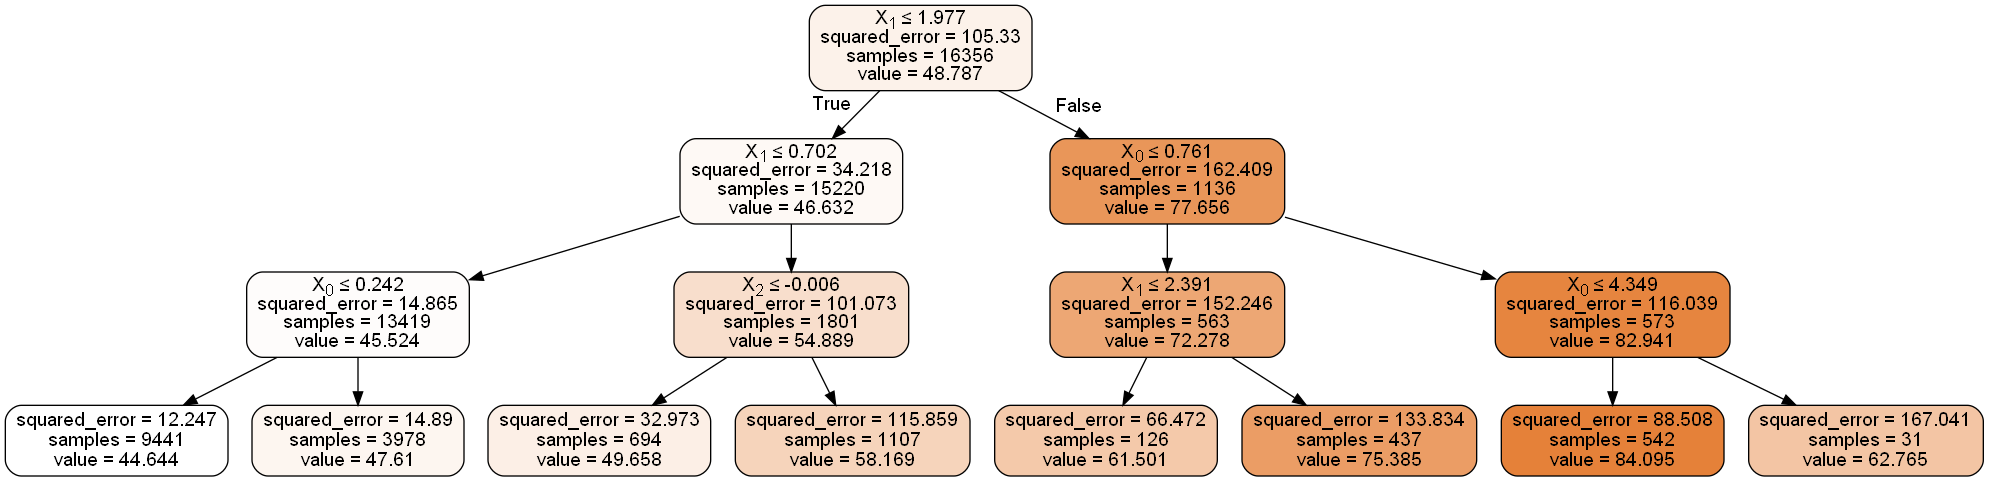

In [158]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
from sklearn.metrics import mean_squared_error
# 所有訓練集的資料拿來預測|
Optimal_tree_reg_model = tree_reg_grid_search.best_estimator_


dot_data =  tree.export_graphviz(Optimal_tree_reg_model, out_file=None, 
                         #eature_names=anesthesia_train_parameter,  
                         #lass_names=iris.target_names,  
                         max_depth=3,
                         filled=True, rounded=True,  
                         special_characters=True)

#jupyter 顯示圖片
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [159]:

anesthesia_test_set_predictions = Optimal_tree_reg_model.predict(anesthesia_test_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Optimal_tree_reg_test_set_mse = mean_squared_error(anesthesia_test_set_labels, anesthesia_test_set_predictions)
Optimal_tree_reg_test_set_rmse = np.sqrt(Optimal_tree_reg_test_set_mse)
print('Optimal_tree_reg_test_set_rmse = ',Optimal_tree_reg_test_set_rmse)

Optimal_tree_reg_test_set_rmse =  5.354121270380968


In [160]:
# 使用均方根誤差 (Root Mean Square Error, RMSE) 作為性能指標
#from sklearn.metrics import mean_squared_error

# 所有訓練集的資料拿來預測
Optimal_tree_reg_model_predictions = Optimal_tree_reg_model.predict(anesthesia_train_set_prepared)
# 計算預測結果與正確答案之間的 RMSE
Optimal_tree_reg_mse = mean_squared_error(anesthesia_train_set_labels, Optimal_tree_reg_model_predictions)
Optimal_tree_reg_rmse = np.sqrt(Optimal_tree_reg_mse)
print('Optimal_tree_reg_rmse = ',Optimal_tree_reg_rmse)

Optimal_tree_reg_rmse =  5.221933333596613


In [161]:
#from sklearn.model_selection import cross_val_score

Optimal_tree_reg_scores = cross_val_score(Optimal_tree_reg_model, anesthesia_train_set_prepared, anesthesia_train_set_labels,
                             scoring="neg_mean_squared_error", cv=5)
Optimal_tree_reg_rmse_scores = np.sqrt(-Optimal_tree_reg_scores)

Optimal_tree_reg_rmse_mean_scores = Optimal_tree_reg_rmse_scores.mean()
print("cross_val_score_mean_RMSE =",Optimal_tree_reg_rmse_mean_scores)

cross_val_score_mean_RMSE = 5.230948033645312


In [162]:
display_scores(Optimal_tree_reg_rmse_scores)

Cross_val_RMSE: [5.15042398 5.25017295 5.24958451 5.10220636 5.40235238]
Cross_val_Mean RMSE: 5.230948033645312
Cross_val_RMSE Standard deviation: 0.10310665104558979


In [163]:
Optimal_tree_reg_model = tree_reg_grid_search.best_estimator_
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

# 注意：這裡不是用 fit_transform，而是 transform
Optimal_tree_reg_predictions = Optimal_tree_reg_model.predict(X_test_prepared)

Optimal_tree_reg_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, Optimal_tree_reg_predictions)
Optimal_tree_reg_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, Optimal_tree_reg_predictions)
Optimal_tree_reg_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, Optimal_tree_reg_predictions)
Optimal_tree_reg_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average, Optimal_tree_reg_predictions)

Optimal_tree_reg_test_rmse_for_first_Doctor = np.sqrt(Optimal_tree_reg_mse_for_first_Doctor)
Optimal_tree_reg_test_rmse_for_second_Doctor = np.sqrt(Optimal_tree_reg_mse_for_second_Doctor)
Optimal_tree_reg_test_rmse_for_third_Doctor= np.sqrt(Optimal_tree_reg_mse_for_third_Doctor)
Optimal_tree_reg_test_rmse_for_3Doctors_average = np.sqrt(Optimal_tree_reg_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("Optimal_tree_reg_test_rmse_for_first_Doctor_labels =",Optimal_tree_reg_test_rmse_for_first_Doctor)
print("Optimal_tree_reg_test_rmse_for_second_Doctor_labels =",Optimal_tree_reg_test_rmse_for_second_Doctor)
print("Optimal_tree_reg_test_rmse_for_third_Doctor_labels =",Optimal_tree_reg_test_rmse_for_third_Doctor)
print("Optimal_tree_reg_test_rmse_for_3Doctors_average_labels =",Optimal_tree_reg_test_rmse_for_3Doctors_average)

<class 'pandas.core.series.Series'>
Optimal_tree_reg_test_rmse_for_first_Doctor_labels = 7.153955366277553
Optimal_tree_reg_test_rmse_for_second_Doctor_labels = 8.281190567445305
Optimal_tree_reg_test_rmse_for_third_Doctor_labels = 5.657124281360579
Optimal_tree_reg_test_rmse_for_3Doctors_average_labels = 5.7499241845882985


In [164]:
Optimal_tree_reg_train_score = Optimal_tree_reg_model.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Optimal_tree_reg_test_score = Optimal_tree_reg_model.score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("Optimal_tree_reg_train_score =",Optimal_tree_reg_train_score)
print("Optimal_tree_reg_train_score =",Optimal_tree_reg_test_score)

Optimal_tree_reg_train_score = 0.7411117192630137
Optimal_tree_reg_train_score = 0.7336906880721458


In [165]:
Optimal_tree_reg_train_score = Optimal_tree_reg_model.score(anesthesia_train_set_prepared, anesthesia_train_set_labels)
Optimal_tree_reg_test_score = Optimal_tree_reg_model.score(anesthesia_test_set_two_surgery_prepared,anesthesia_test_set_two_surgery_labels)
print("Optimal_tree_reg_train_score =",Optimal_tree_reg_train_score)
print("Optimal_tree_reg_train_score =",Optimal_tree_reg_test_score)

Optimal_tree_reg_train_score = 0.7411117192630137
Optimal_tree_reg_train_score = 0.5583587097760114


### 分析最佳模型及其錯誤

In [188]:

lin_regression = [lin_reg_train_score,
                  lin_reg_test_score,
                  lin_rmse ,
                  lin_rmse_mean_scores,
                  #lin_reg_test_rmse_for_3Doctors_average
                  6.268256]

Four_degree_lin_regression = [
                               Four_degree_lin_reg_train_score,
                               Four_degree_lin_reg_test_score,
                               Four_degree_lin_reg_rmse ,
                               Four_degree_lin_reg_rmse_mean_scores,
                               Four_degree_lin_reg_test_rmse_for_3Doctors_average]

SVM = [svm_reg_train_score,
       svm_reg_test_score,
       svm_rmse,
       svm_rmse_mean_scores,
       svm_reg_test_rmse_for_3Doctors_average]

Forest_reg = [forest_reg_train_score,
              forest_reg_test_score,
              forest_rmse,
              forest_rmse_mean_scores,
              #7.148649,
              forest_reg_test_rmse_for_3Doctors_average]

Optimal_forest_reg = [Optimal_forest_reg_train_score,
                      Optimal_forest_reg_test_score,
                      Optimal_forest_reg_rmse,
                      Optimal_forest_reg_rmse_mean_scores,
                      #5.337111,
                      Optimal_forest_reg_test_rmse_for_3Doctors_average]

tree_regression = [tree_reg_train_score,
                   tree_reg_test_score,
                   tree_rmse ,
                   tree_rmse_mean_scores,
                   #7.912644,
                   tree_reg_test_rmse_for_3Doctors_average]

Optimal_tree_reg = [Optimal_tree_reg_train_score,
                    Optimal_tree_reg_test_score,
                    Optimal_tree_reg_rmse,
                    Optimal_tree_reg_rmse_mean_scores,
                    Optimal_tree_reg_test_rmse_for_3Doctors_average,]

compare_props = pd.DataFrame({
    "First_train_set(EMG、NBP_Sys、BIS)": ["train_score(accuracy)", "test_score(accuracy)", "train RMSE", "cross_val_score_mean RMSE",
         "test_set RMSE with 3 Doctors average labels"],
    "lin_reg": lin_regression,
    "Four_degree_lin_reg": Four_degree_lin_regression,
    "SVM": SVM,
    "Optimal_forest_reg": Optimal_forest_reg,
    "forest_reg": Forest_reg,
    "Optimal_tree_reg": Optimal_tree_reg,
    "tree_reg": tree_regression
})
compare_props


,First_train_set(EMG、NBP_Sys、BIS),lin_reg,Four_degree_lin_reg,SVM,Optimal_forest_reg,forest_reg,Optimal_tree_reg,tree_reg
0,train_score(accuracy),0.574845,0.757495,0.528444,0.980901,0.979012,0.741112,0.985094
1,test_score(accuracy),0.586759,0.607078,0.357757,0.347746,0.248663,0.558359,0.141653
2,train RMSE,6.691892,5.054000,7.047608,1.418345,1.486810,5.221933,1.253000
3,cross_val_score_mean RMSE,6.694666,5.091466,7.053937,2.421165,2.442213,5.230948,2.808004
4,test_set RMSE with 3 Doctors average labels,6.268256,5.423508,6.933889,6.987722,7.499716,5.749924,8.016020


Saving figure gradient_descent_paths_plot


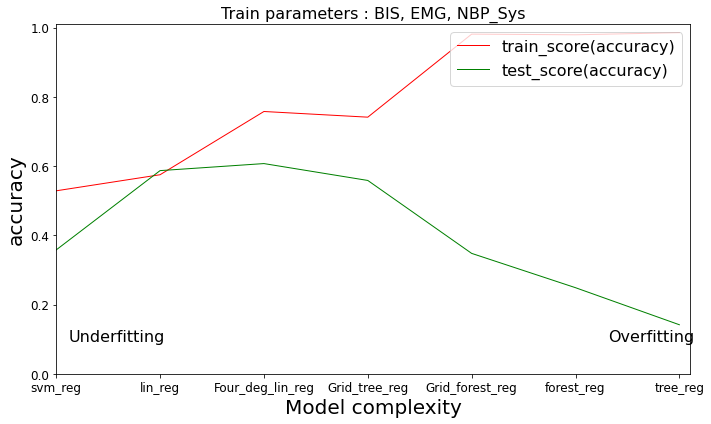

In [192]:

model_train_score_accuracy = [
                              svm_reg_train_score,
                              lin_reg_train_score,
                              Four_degree_lin_reg_train_score,
                              Optimal_tree_reg_train_score,
                              Optimal_forest_reg_train_score,
                              forest_reg_train_score,
                              tree_reg_train_score
                             ]
model_test_score_accuracy = [
                             svm_reg_test_score,
                             lin_reg_test_score,
                             Four_degree_lin_reg_test_score,
                             Optimal_tree_reg_test_score,
                             Optimal_forest_reg_test_score,
                             forest_reg_test_score,
                             tree_reg_test_score
                             ]
model_array = [
               "svm_reg",
               "lin_reg",
               "Four_deg_lin_reg",
               "Grid_tree_reg",
               "Grid_forest_reg",
               "forest_reg",
               "tree_reg"
              ]

plt.figure(figsize=(10, 6))
plt.plot(model_array, model_train_score_accuracy, "r-", linewidth=1, label="train_score(accuracy)")
plt.plot(model_array, model_test_score_accuracy, "g-", linewidth=1, label="test_score(accuracy)")

plt.title("Train parameters : BIS, EMG, NBP_Sys", fontsize=16)
plt.figtext(0.1,0.2,'Underfitting',color='black',fontsize=16)
plt.figtext(0.85,0.2,'Overfitting',color='black',fontsize=16)
#plt.annotate('sweet spot',xy=(3.1,0.80),xytext=(2.2,0.4), fontsize=16,arrowprops=dict(facecolor='blue', shrink=0.25))

plt.legend(loc="upper right", fontsize=16)
plt.xlabel("Model complexity", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.axis([ 0, 6.1, 0, 1.009])
save_fig("gradient_descent_paths_plot")
plt.show()


### 以測試集來評估系統

Saving figure gradient_descent_paths_plot


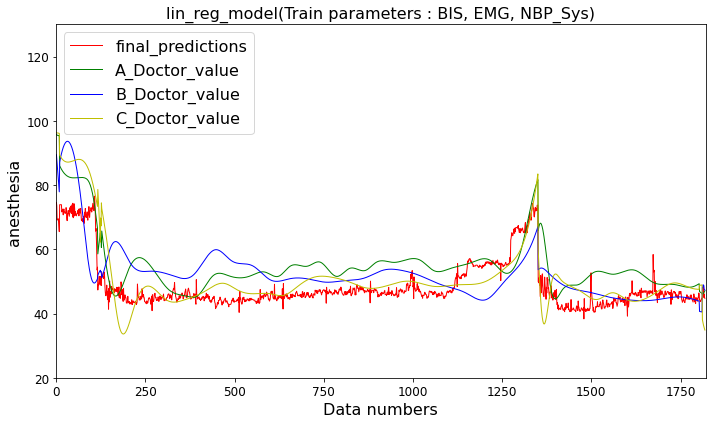

In [193]:

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)# 注意：這裡不是用 fit_transform，而是 transform
lin_reg_final_predictions = lin_reg.predict(X_test_prepared)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()


lin_reg_final_predictions_len = range(1,len(lin_reg_final_predictions)+1,1)
lin_reg_final_predictions_len_array = np.array(lin_reg_final_predictions_len)


plt.figure(figsize=(10,6))
plt.plot(lin_reg_final_predictions_len, lin_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(lin_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(lin_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(lin_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("lin_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()



Saving figure gradient_descent_paths_plot


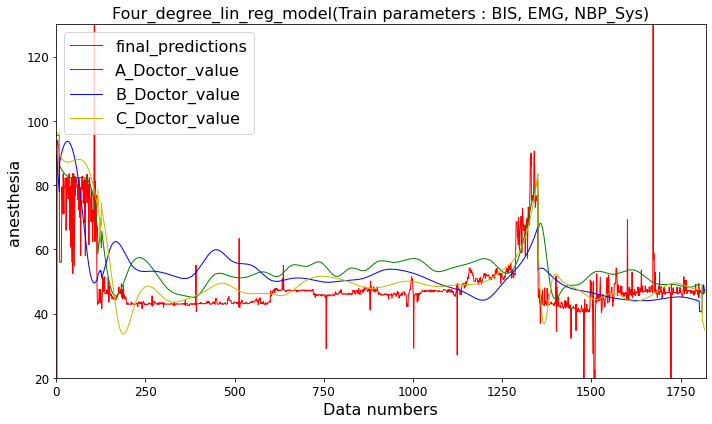

In [194]:

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)# 注意：這裡不是用 fit_transform，而是 transform
Second_order_lin_reg_final_predictions = Second_order_lin_reg.predict(X_test_prepared)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()


Second_order_lin_reg_final_predictions_len = range(1,len(Second_order_lin_reg_final_predictions)+1,1)
Second_order_lin_reg_final_predictions_len_array = np.array(Second_order_lin_reg_final_predictions_len)


plt.figure(figsize=(10,6))
plt.plot(Second_order_lin_reg_final_predictions_len, Second_order_lin_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(Second_order_lin_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(Second_order_lin_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(Second_order_lin_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("Four_degree_lin_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()


Saving figure gradient_descent_paths_plot


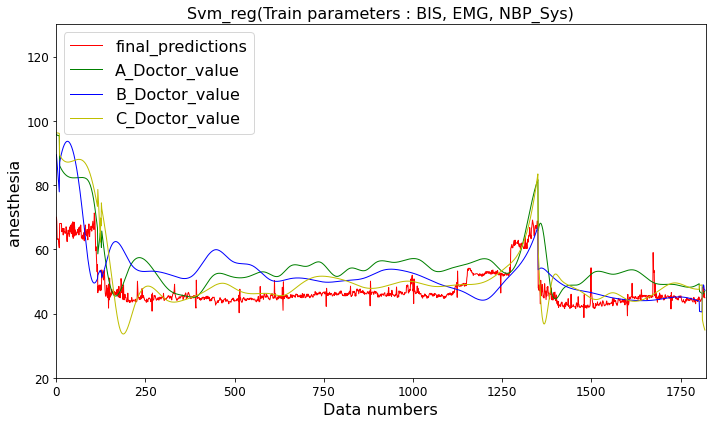

In [195]:
# 試試看大名鼎鼎的支援向量機

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)# 注意：這裡不是用 fit_transform，而是 transform
svm_reg_final_predictions = svm_reg.predict(X_test_prepared)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()

svm_reg_final_predictions_len = range(1,len(svm_reg_final_predictions)+1,1)
svm_reg_final_predictions_len_array = np.array(svm_reg_final_predictions_len)

plt.figure(figsize=(10,6))
plt.plot(svm_reg_final_predictions_len_array, svm_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(svm_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(svm_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(svm_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("Svm_reg(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

Saving figure gradient_descent_paths_plot


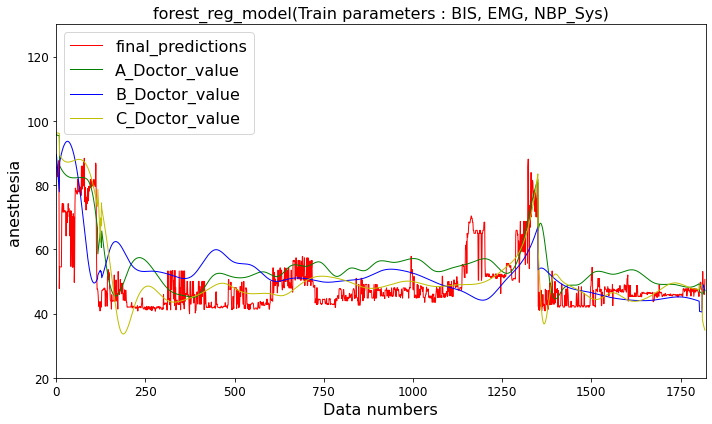

In [196]:
# 選用另一種模型：隨機森林
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery) # 注意：這裡不是用 fit_transform，而是 transform
forest_reg_final_predictions = forest_reg.predict(X_test_prepared)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()

forest_reg_final_predictions_len = range(1,len(forest_reg_final_predictions)+1,1)
forest_reg_final_predictions_len_array = np.array(forest_reg_final_predictions_len)

plt.figure(figsize=(10,6))
plt.plot(forest_reg_final_predictions_len_array, forest_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(forest_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(forest_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(forest_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("forest_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

Saving figure gradient_descent_paths_plot


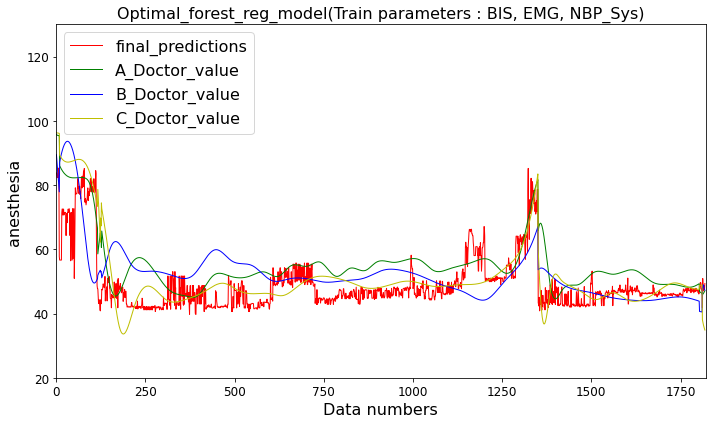

In [197]:
X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery) # 注意：這裡不是用 fit_transform，而是 transform
Optimal_forest_reg_final_predictions = Optimal_forest_reg_model.predict(X_test_prepared)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()

Optimal_forest_reg_final_predictions_len = range(1,len(Optimal_forest_reg_final_predictions)+1,1)
Optimal_forest_reg_final_predictions_len_array = np.array(Optimal_forest_reg_final_predictions_len)

plt.figure(figsize=(10,6))
plt.plot(Optimal_forest_reg_final_predictions_len_array, Optimal_forest_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(Optimal_forest_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(Optimal_forest_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(Optimal_forest_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("Optimal_forest_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

Saving figure gradient_descent_paths_plot


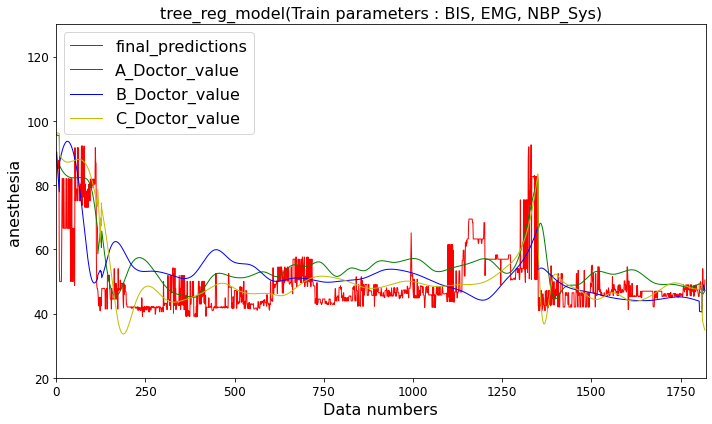

In [206]:
# 選一個複雜一點的模型來訓練


X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)
 # 注意：這裡不是用 fit_transform，而是 transform
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(anesthesia_train_set_prepared, anesthesia_train_set_labels)
tree_reg_final_predictions = tree_reg.predict(X_test_prepared)

tree_reg_final_predictions_len = range(1,len(tree_reg_final_predictions)+1,1)
tree_reg_final_predictions_len_array = np.array(tree_reg_final_predictions_len)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()



plt.figure(figsize=(10,6))
plt.plot(tree_reg_final_predictions_len_array, tree_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(tree_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(tree_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(tree_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("tree_reg_model(Train parameters : BIS, EMG, NBP_Sys)",fontsize=16)
plt.legend(loc="upper left",fontsize=16)
plt.xlabel("Data numbers",fontsize=16)
plt.ylabel("anesthesia",fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

Saving figure gradient_descent_paths_plot


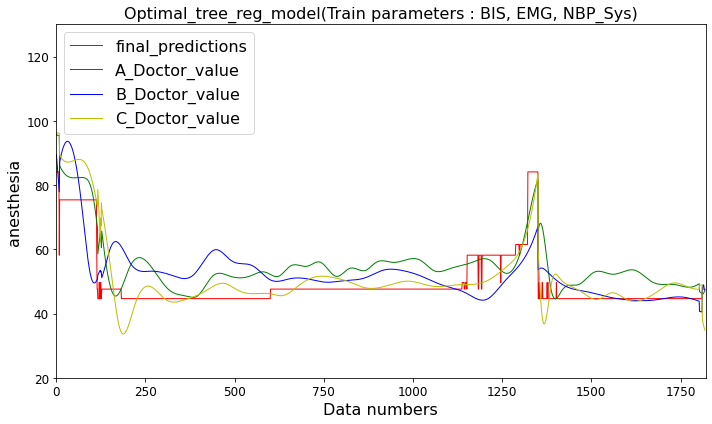

In [207]:
Optimal_tree_reg_final_model = tree_reg_grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(anesthesia_test_set_two_surgery)
 # 注意：這裡不是用 fit_transform，而是 transform
Optimal_tree_reg_final_predictions = Optimal_tree_reg_final_model.predict(X_test_prepared)

Optimal_tree_reg_final_predictions_len = range(1,len(Optimal_tree_reg_final_predictions)+1,1)
Optimal_tree_reg_final_predictions_len_array = np.array(Optimal_tree_reg_final_predictions_len)

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()



plt.figure(figsize=(10,6))
plt.plot(Optimal_tree_reg_final_predictions_len_array, Optimal_tree_reg_final_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(Optimal_tree_reg_final_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(Optimal_tree_reg_final_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(Optimal_tree_reg_final_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("Optimal_tree_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()

### 包括資料預處理以及預測的完整流水線

In [208]:

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("Six_order_lin_reg", Pipeline(memory=None,
                                  steps=[('poly_features',PolynomialFeatures(degree=4, include_bias=False,
                                                                             interaction_only=False, order='C')),
                                         ('lin_reg',LinearRegression(copy_X=True, fit_intercept=True,
                                                                     n_jobs=None,normalize=False))],verbose=False))
])

full_pipeline_with_predictor.fit(anesthesia_train_set, anesthesia_train_set_labels)
full_pipeline_with_predictor_predictions = full_pipeline_with_predictor.predict(anesthesia_test_set_two_surgery)
print(full_pipeline_with_predictor_predictions[0:15])
print(anesthesia_test_set_two_surgery_labels[0:15])

[76.0388215  78.24318585 77.1703222  77.71390761 77.71390761 78.38944818
 76.62660122 72.21686676 68.52560784 84.9599627  84.9599627  84.9599627
 84.9599627  84.9599627  84.9599627 ]
0     93.806636
1     93.272169
2     92.746935
3     92.230682
4     91.723158
5     91.224112
6     90.733293
7     90.250448
8     89.775326
9     87.482544
10    87.526373
11    87.568584
12    87.609021
13    87.647526
14    87.683942
Name: Average_doctor_value, dtype: float64


C:\Users\User\anaconda3\envs\torch-gpu\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [209]:
full_pipeline_with_predictor_predictions = full_pipeline_with_predictor.predict(anesthesia_test_set_two_surgery)

y_test_first_Doctor = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
y_test_second_Doctor = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
y_test_third_Doctor = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()
y_test_3Doctors_average = anesthesia_test_set_two_surgery["Average_doctor_value"].copy()

full_pipeline_with_predictor_mse_for_first_Doctor = mean_squared_error(y_test_first_Doctor, full_pipeline_with_predictor_predictions)
full_pipeline_with_predictor_mse_for_second_Doctor = mean_squared_error(y_test_second_Doctor, full_pipeline_with_predictor_predictions)
full_pipeline_with_predictor_mse_for_third_Doctor = mean_squared_error(y_test_third_Doctor, full_pipeline_with_predictor_predictions)
full_pipeline_with_predictor_mse_for_3Doctors_average = mean_squared_error(y_test_3Doctors_average,full_pipeline_with_predictor_predictions)

full_pipeline_with_predictor_rmse_for_first_Doctor = np.sqrt(full_pipeline_with_predictor_mse_for_first_Doctor)
full_pipeline_with_predictor_rmse_for_second_Doctor = np.sqrt(full_pipeline_with_predictor_mse_for_second_Doctor)
full_pipeline_with_predictor_rmse_for_third_Doctor= np.sqrt(full_pipeline_with_predictor_mse_for_third_Doctor)
full_pipeline_with_predictor_rmse_for_3Doctors_average = np.sqrt(full_pipeline_with_predictor_mse_for_3Doctors_average)

print(type(y_test_first_Doctor))
print("full_pipeline_with_predictor_predictions_rmse_for_first_Doctor =",full_pipeline_with_predictor_rmse_for_first_Doctor)
print("full_pipeline_with_predictor_predictions_rmse_for_second_Doctor =",full_pipeline_with_predictor_rmse_for_second_Doctor)
print("full_pipeline_with_predictor_predictions_rmse_for_third_Doctor =",full_pipeline_with_predictor_rmse_for_third_Doctor)
print("full_pipeline_with_predictor_predictions_rmse_for_3Doctors_average =",full_pipeline_with_predictor_rmse_for_3Doctors_average)



<class 'pandas.core.series.Series'>
full_pipeline_with_predictor_predictions_rmse_for_first_Doctor = 7.49633110453496
full_pipeline_with_predictor_predictions_rmse_for_second_Doctor = 7.992080290503921
full_pipeline_with_predictor_predictions_rmse_for_third_Doctor = 5.181343626237412
full_pipeline_with_predictor_predictions_rmse_for_3Doctors_average = 5.607711470962877


In [210]:
full_pipeline_with_predictor_train_score = full_pipeline_with_predictor["Six_order_lin_reg"].score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
full_pipeline_with_predictor_test_score = full_pipeline_with_predictor["Six_order_lin_reg"].score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
print("full_pipeline_with_predictor_train_score =",full_pipeline_with_predictor_train_score)
print("full_pipeline_with_predictor_test_score =",full_pipeline_with_predictor_test_score)

full_pipeline_with_predictor_train_score = 0.7776651001951077
full_pipeline_with_predictor_test_score = 0.7776651001951077


In [211]:
full_pipeline_with_predictor_train_score = full_pipeline_with_predictor["Six_order_lin_reg"].score(anesthesia_test_set_prepared, anesthesia_test_set_labels)
full_pipeline_with_predictor_test_score = full_pipeline_with_predictor["Six_order_lin_reg"].score(anesthesia_test_set_two_surgery_prepared, anesthesia_test_set_two_surgery_labels)
print("full_pipeline_with_predictor_train_score =",full_pipeline_with_predictor_train_score)
print("full_pipeline_with_predictor_test_score =",full_pipeline_with_predictor_test_score)

full_pipeline_with_predictor_train_score = 0.7776651001951077
full_pipeline_with_predictor_test_score = 0.6070782556256128


Saving figure gradient_descent_paths_plot


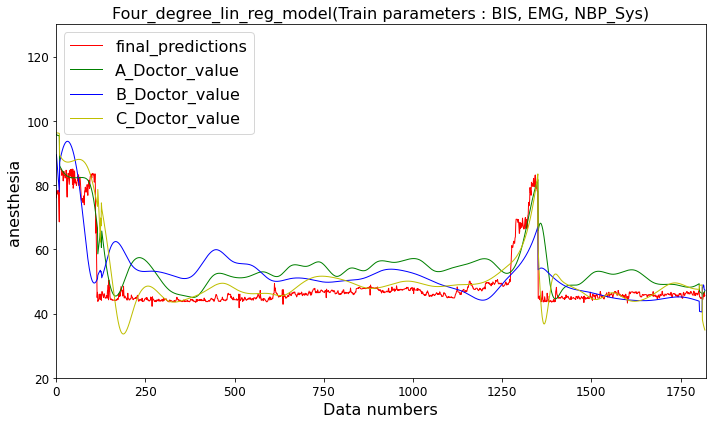

In [212]:


full_pipeline_with_predictor_predictions

anesthesia_first_surgery_A_Doctor_label = anesthesia_test_set_two_surgery["A_Doctor_value"].copy()
anesthesia_first_surgery_B_Doctor_label = anesthesia_test_set_two_surgery["B_Doctor_value"].copy()
anesthesia_first_surgery_C_Doctor_label = anesthesia_test_set_two_surgery["C_Doctor_value"].copy()


full_pipeline_with_predictor_predictions_len = range(1,len(full_pipeline_with_predictor_predictions)+1,1)
full_pipeline_with_predictor_predictions_len_array = np.array(full_pipeline_with_predictor_predictions_len)


plt.figure(figsize=(10,6))
plt.plot(full_pipeline_with_predictor_predictions_len, full_pipeline_with_predictor_predictions, "r-", linewidth=1, label="final_predictions")
plt.plot(full_pipeline_with_predictor_predictions_len_array, anesthesia_first_surgery_A_Doctor_label, "g-", linewidth=1, label="A_Doctor_value")
plt.plot(full_pipeline_with_predictor_predictions_len_array, anesthesia_first_surgery_B_Doctor_label, "b-", linewidth=1, label="B_Doctor_value")
plt.plot(full_pipeline_with_predictor_predictions_len_array, anesthesia_first_surgery_C_Doctor_label, "y-", linewidth=1, label="C_Doctor_value")

plt.title("Four_degree_lin_reg_model(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
#plt.title("full_pipeline_with_predictor_predictions(Train parameters : BIS, EMG, NBP_Sys)", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Data numbers", fontsize=16)
plt.ylabel("anesthesia", fontsize=16)
plt.axis([0, 1820, 20, 130])
save_fig("gradient_descent_paths_plot")
plt.show()


### 使用 joblib 保存 Scikit-Learn 模型

In [213]:
import joblib
my_model = full_pipeline_with_predictor

In [214]:
#from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl")

['my_model.pkl']

In [215]:
my_model_loaded = joblib.load("my_model.pkl")

In [216]:
type(my_model_loaded)

sklearn.pipeline.Pipeline

In [217]:
print("predict=", my_model_loaded.predict(anesthesia_test_set_two_surgery))

predict= [76.0388215  78.24318585 77.1703222  ... 46.58159806 45.39358876
 45.66992206]


In [218]:
print("labels=", anesthesia_test_set_two_surgery["Average_doctor_value"])

labels= 0       93.806636
1       93.272169
2       92.746935
3       92.230682
4       91.723158
          ...    
1813    43.856278
1814    43.721217
1815    43.269216
1816    43.166811
1817    43.080136
Name: Average_doctor_value, Length: 1818, dtype: float64
